<a href="https://colab.research.google.com/github/pavanreddy-ml/BlinkShot/blob/main/Notebooks/Aircraft_Intelligent_Diagnostics_V13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anomaly Detector for Analysis of General Aviation Aircraft

#Introduction

This Colaboratory notebook is a tool to analyse flight logs for anomalies. It uses deep-learning anomaly detection to learn normal patterns and correlations from past flights, detect unusual characteristics from new flights, and provide an explanation for anomalies.


---



For example, a log entry might be anomalous because the oil temperature is too high and the oil pressure is too low, which may indicate an oil leak. The machine learning model might express this condition with a blame of 55% oil temperature and 45% oil pressure.


---



The method of anomaly detection was originally developed at Google to detect faulty HVAC systems in Google office buildings, but the same approach can be applied to airplanes or any other devices that generate timestamped numeric data logs.

Flight data logs should be inspected using fixed rules developed by the aircraft and engine manufacturer. However, this tool is meant as a supplement to establish operating conditions and not a replacement.


##Quickstart
Simply execute the following cell that performs a pip-install of required libraries from the github repo.




In [1]:
!pip install pip==22.0.3
!pip install virtualenv
!git clone https://github.com/google/madi.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pip-tools 6.13.0 requires pip>=22.2, but you have pip 22.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 KB 42.4 MB/s eta 0:00:00
Cloning into 'madi'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 376 (delta 52), reused 50 (delta 39), pack-reused 299
Receiving objects: 100% (376/376), 1.85 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (206/206), done.


Remove `python_requires = >=3.6.*` from setup.cfg.

Go to Files (left menu) >> madi >> setup.cfg.

Delete the line `python_requires = >=3.6.*` and save.

In [2]:
# Remove python_requires = >=3.6.* from setup.cfg

!pip install -e madi
!pip install build
!python3 -m build madi
!pip install wandb -Uq
!pip install pandas-tfrecords

print("Restart Runtime now.")

Obtaining file:///content/madi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for madi (pyproject.toml) ... done
  Created wheel for madi: filename=madi-0.0.1-0.editable-py3-none-any.whl size=6418 sha256=b9d92be7d1df0c13fbca87a41048c9c719dcccf4750a6712cc3d94253428652d
  Stored in directory: /tmp/pip-ephem-wheel-cache-36j9p_rw/wheels/4d/e6/39/08114827eb46c03ed955f56b9234d739b96ce8981129a1b503
Successfully built madi
* Creating virtualenv isolated environment...
* Installing packages in isolated environment... (setuptools>=40.8.0, wheel)
* Getting build dependencies for sdist...
running egg_info
writing src/madi.egg-info/PKG-INFO
writing dependency_links to src/madi.egg-info/dependency_links.txt
writing requirements to src/madi.egg-info/requires.txt
writing top-level names to src/madi.egg-info/top_level.txt
re

Restart the runtime before continuing.

In [1]:
#@title Colab Imports
import sys
import time
import madi
import os
import abc
import collections
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import Tuple, List, Mapping, Sequence, Optional
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl

import json
import joblib
from io import BytesIO
from PIL import Image
from IPython.display import Image as IPImage
from datetime import datetime

import seaborn as sns

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from scipy import signal
from scipy.fft import fftshift

import glob
from google.colab import drive

from madi.datasets import gaussian_mixture_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.isolation_forest_detector import IsolationForestAd
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from madi.detectors.one_class_svm import OneClassSVMAd
from madi.detectors.neg_sample_random_forest import NegativeSamplingRandomForestAd
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from google.colab import drive


from absl import logging
from madi.detectors.base_detector import BaseAnomalyDetectionAlgorithm


import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

import warnings
warnings.filterwarnings("ignore")

!pip install lime
!pip install shap
import shap
import lime
import lime.lime_tabular

In [2]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()


def plot_pair_plots(observations):
  variables  = list(observations)
  if 'class_label' in variables:
    variables.remove('class_label')
    cell_count = len(variables) -1
  fig, ax = plt.subplots(nrows = cell_count, ncols = cell_count)

  if 'class_label' in observations.columns:

    anomalous_observations = observations[observations['class_label'] ==0]
  else:
    anomalous_observations = None

  fig.set_figheight(10 * cell_count)
  fig.set_figwidth(10* cell_count)
  rx = 1;
  for row in ax:
      y_label = variables[rx]
      cx = 0
      for col in row:
        if rx > cx:
          x_label = variables[cx]

          col.plot(observations[x_label], observations[y_label],  '.',markersize = 4.0,   color='green',  alpha=0.8)

          if anomalous_observations is not None:
            col.plot(anomalous_observations[x_label], anomalous_observations[y_label],  '.',markersize = 5.0,   color='red',  alpha=0.8)


          col.set_xlabel(x_label)
          col.set_ylabel(y_label)
        else:
          col.axis('off')
        cx = cx + 1
      rx = rx + 1



def get_single_ad_timeseries(ad: BaseAnomalyDetectionAlgorithm, observations: pd.DataFrame) -> pd.DataFrame:
  """Returns the single timeseries of predictions."""

  if 'class_label' in observations.columns:
    observations = observations.drop(columns = ['class_label'])
  return ad.predict(observations)['class_prob']



def get_ad_timeseries(ad_dict: Mapping[str,
                                       Sequence[BaseAnomalyDetectionAlgorithm]],
                      observations: pd.DataFrame) -> pd.DataFrame:
  """Returns a DF of predictions, one col for each AD."""
  preds = {}
  cols = []
  for ad_name in ad_dict:
    preds[ad_name] = get_single_ad_timeseries(ad_dict[ad_name][2], observations)
    cols.append(ad_name)
  return pd.DataFrame(preds, columns= cols)


def plot_variable_timeseries(observations, variable_name, label, predictions = None, anomaly_smoothing_kernel = 15):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()
  fig.set_figheight(15)
  fig.set_figwidth(50)
  ax.tick_params(axis = 'x', labelsize = 24)
  ax.tick_params(axis = 'y', labelsize = 24)
  ax2.tick_params(axis = 'y', labelsize = 24)
  ax2.set_ylim(-0.05, 1.05)
  ax2.set_ylabel("Anomaly Score", color='red', fontsize=14)
  ax.xaxis.set_minor_locator(mdates.MinuteLocator())
  ax.xaxis.set_minor_locator(mdates.HourLocator())

  # anomalous_observations = observations[observations['class_label'] ==0]

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  timestamps = [ii[2] for ii in observations.index]

  ax.plot(timestamps, observations[variable_name], label = variable_name, linewidth = 1.0, marker = None, color = 'green')

  if 'class_label' in observations.columns:
    anomalous_observations = observations[observations['class_label'] ==0]
    anomalous_timestamps = [ii[2] for ii in anomalous_observations.index]
    ax.plot(anomalous_timestamps, anomalous_observations[variable_name], label = variable_name, linewidth = 1.0, marker = '.', color = 'red')


  if predictions is not None:
    for ad_name in predictions.columns:
      ad_predictions = 1 - predictions[ad_name]
      kernel_size = anomaly_smoothing_kernel
      kernel = np.ones(kernel_size) / kernel_size
      ad_smoothed = np.convolve(ad_predictions, kernel, mode='same')

      ax2.plot(timestamps, ad_predictions, label = ad_name, linewidth = 1.0, marker = None, color = 'lightgray')
      ax2.plot(timestamps, ad_smoothed, label = ad_name, linewidth = 1.0, marker = None, color = 'orange')


  for tick in ax.get_xticklabels():
    tick.set_rotation(0)


  plt.title('%s timeseries %s' %(variable_name, label), fontsize = 24)
  plt.legend(loc='lower left', fontsize = 16)
  plt.grid(True)
  plt.show()


In [3]:
# @title Utilities for Auxiliary Features


def extract_categorical_columns(flight_data: Mapping[tuple[str, str, str], tuple[str, pd.DataFrame]]) -> Mapping[str, set[str]]:
  categorical_columns = collections.defaultdict(set)

  for flight_key in flight_data:
    df = flight_data[flight_key][1].dropna()

    for col, col_type in df.dtypes.items():
      if col_type == 'object':
        categorical_columns[col].update(set(df[col]))


  return categorical_columns




class BaseAuxiliaryFeature(metaclass= abc.ABCMeta):
  """Base class for augmenting raw feature with auxiliary features."""


  @abc.abstractmethod
  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

  @property
  @abc.abstractmethod
  def feature_names(self) -> Sequence[str]:
    """Returns the name of the features."""



class TempMeanDeviationFeature(BaseAuxiliaryFeature):


  def __init__(self, ncyl = 6):
    self._FEATURE_HEADER = 'aux_avgdev'
    self._ncyl = ncyl
    self._cht_feature_names = ["CHT%d" %i for i in range(1,ncyl+1)]
    self._egt_feature_names = ["EGT%d" %i for i in range(1,ncyl+1)]



  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    means_cht = flight_data[self._cht_feature_names].mean(axis = 1)
    means_egt = flight_data[self._egt_feature_names].mean(axis = 1)

    # CHT features
    for i, fname in enumerate(self._cht_feature_names):
      flight_data['%s_%s' %(self._FEATURE_HEADER, fname)] = flight_data[fname] - means_cht

    # EGT features
    for i, fname in enumerate(self._egt_feature_names):
      flight_data['%s_%s' %(self._FEATURE_HEADER, fname)] = flight_data[fname] - means_egt

    return flight_data


  @property
  def feature_names(self) -> Sequence[str]:
    return ['%s_%s' %(self._FEATURE_HEADER, fname) for fname in self._cht_feature_names + self._egt_feature_names]

class PcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_pca_%d" %i for  i in range(npca)]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    pca_trans = self._pca.transform(flight_data[self._selected_features])
    df_pca_features = pd.DataFrame(pca_trans, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names


class PcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_pca_%d" %i for  i in range(npca)]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    pca_trans = self._pca.transform(flight_data[self._selected_features])
    df_pca_features = pd.DataFrame(pca_trans, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names



class DiffPcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_diffpca_%s" %col for  col in selected_features]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    X = np.array(flight_data[self._selected_features])
    components = self._pca.transform(X)
    X_pca = self._pca.inverse_transform(components)
    pca_dif = X - X_pca
    df_pca_features = pd.DataFrame(pca_dif, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names
class FourierAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, selected_features: Sequence[str], num_fourier_coeffs = 4):
    self._selected_features = selected_features
    self._num_fourier_coeffs = num_fourier_coeffs
    self._feature_names = None


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    (n_points, n_features) = flight_data.shape
    fnames = []


    for feature in self._selected_features:

      if feature.startswith('CHT'):
        sig = flight_data[feature] -  np.mean(flight_data[['CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6']], axis = 1)
      elif feature.startswith('EGT'):
        sig = flight_data[feature] -  np.mean(flight_data[['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']], axis = 1)
      else:
        sig = flight_data[feature]


      _, _, Sxx = self._compute_fourier_coeffs(sig)

      (n_fourier_features, n_fourier_points) = Sxx.shape
      diff_points = n_points - n_fourier_points
      points_prepend = int(diff_points/2.0)
      points_postpend = diff_points - points_prepend
      for f in range(self._num_fourier_coeffs):
        f_array = np.concatenate([np.zeros(points_prepend), Sxx[f, :],np.zeros(points_postpend)])
        fname = 'aux_fft%d_%s' %(f, feature)
        flight_data[fname] = f_array
        fnames.append(fname)
    if self._feature_names is None:
      self._feature_names = fnames
    return flight_data


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names

  def _compute_fourier_coeffs(self, series: pd.Series) -> tuple[np.array, np.array, np.array]:
    fs = 1
    f, t, Sxx = signal.spectrogram(series, fs, nperseg = 256, window=('tukey', 0.5),
                                   scaling = 'spectrum', mode = 'magnitude', noverlap=255)

    # f, t, Sxx = signal.spectrogram(series, fs, nperseg = 128, window=('tukey', 0.25),
    #                                scaling = 'spectrum', mode = 'magnitude', noverlap=31)
    return f, t, Sxx


class FlightDurationAuxiliaryFeature(BaseAuxiliaryFeature):
  """Adds actual and normalized flight duration features.  """
  def __init__(self, add_normalized: bool = False, add_minutes = True):
    self._add_normalized = add_normalized
    self._add_minutes = add_minutes
    self._feature_names = {'norm': 'aux_flight_dur_norm', 'minutes':'aux_flight_dur_minutes' }
    if not add_normalized and not add_minutes:
      raise ValueError('Neither add_normalized nor add_minutes were selected.')


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    start_time = flight_data['TIME_UTC'].min()
    end_time = flight_data['TIME_UTC'].max()
    duration_minutes =  (flight_data['TIME_UTC'] - start_time)/60.0
    duration_normalized = duration_minutes / duration_minutes.max()

    if self._add_normalized:
      flight_data[self._feature_names['norm']] = duration_normalized

    if self._add_minutes:
      flight_data[self._feature_names['minutes']] = duration_minutes

    return flight_data

  @property
  def feature_names(self) -> Sequence[str]:
    return list(self._feature_names.values())


class OneHotAuxiliaryFeature(BaseAuxiliaryFeature):
  """Class for augmenting raw feature with auxiliary features."""

  def __init__(self, categorical_columns: Mapping[str, Sequence[str]]):
    self._one_hot_cols = []
    self._categorical_cols = categorical_columns
    self._feature_names = []
    for col in categorical_columns:
      feature_names = [self._to_one_hot_column_name(col, feature) for feature in categorical_columns[col]]
      self._feature_names.extend(feature_names)

  def _to_one_hot_column_name(self, categorical_column_name: str, categorical_value: str):
    return "aux_cat_%s_%s" %(categorical_column_name, categorical_value)

  def _categorical_to_onehot(self, df_flight, column_name):

    categorical_values = self._categorical_cols[column_name]
    for categorical_value in categorical_values:
      one_hot_column_name  = self._to_one_hot_column_name(column_name, categorical_value)
      if one_hot_column_name not in self._one_hot_cols:
        self._one_hot_cols.append(one_hot_column_name)
      df_flight[one_hot_column_name] = [int(v == categorical_value) for v in df_flight[column_name]]
    return df_flight



  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    for col in self._categorical_cols:
      flight_data = self._categorical_to_onehot(flight_data, col)

    return flight_data

  @property
  def feature_names(self) -> Sequence[str]:
    """Returns the name of the features."""
    return self._one_hot_cols




def apply_auxiliary_features(flights: Mapping[tuple[str,str], tuple[str, pd.DataFrame]], auxiliary_features: Mapping[str, BaseAuxiliaryFeature]):

  for flight_key in flights:
    for auxf in auxiliary_features:
      print('Adding auxiliary feature %s to flight %s' %(auxf, flight_key))
      flight_file = flights[flight_key][0]
      flight_data = flights[flight_key][1]
      flight_data = auxiliary_features[auxf].append(flight_data)
      flights[flight_key] = (flight_file, flight_data)

  return flights


In [4]:
# @title Utilities for sampling

def filter_upper_lower_quantiles(
    df_cfr: pd.DataFrame, upper_quantile: float, lower_quantile: float, select_feature_cols: Optional[str] = None
) -> pd.DataFrame:
  df_cfr_qtl = df_cfr.dropna().copy()
  upper_quantile_vals = df_cfr_qtl.quantile(q=upper_quantile)

  lower_quantile_vals = df_cfr_qtl.quantile(q=lower_quantile)

  if select_feature_cols is None:
    select_feature_cols = df_cfr_qtl.columns


  for col in select_feature_cols:
    # Ignore all columns with integer values.
    if all(isinstance(v, int) for v in df_cfr_qtl[col]):
      continue

    upper_cutoff = upper_quantile_vals[col]
    lower_cutoff = lower_quantile_vals[col]

    df_cfr_qtl[col][df_cfr_qtl[col] > upper_cutoff] = np.NaN
    df_cfr_qtl[col][df_cfr_qtl[col] < lower_cutoff] = np.NaN

  return df_cfr_qtl.dropna()

def downsample_cruise(df_flight, vspd_upper_lim: float, vspd_lower_lim: float, gnd_spd_min_lim: float, cruise_fraction: float  = 0.5) -> pd.DataFrame:

  df_cruise = df_flight[(df_flight['VSpd'] <= vspd_upper_lim) & (df_flight['VSpd'] >= vspd_lower_lim) & (df_flight['GndSpd'] >= gnd_spd_min_lim)  ]
  df_critical = df_flight[(df_flight['VSpd'] > vspd_upper_lim) | (df_flight['VSpd'] < vspd_lower_lim) | (df_flight['GndSpd'] < gnd_spd_min_lim ) ]

  print("Before downsampling: Cruise points: %d, and non-cruise points: %d" %(len(df_cruise), len(df_critical)))

  df_cruise = df_cruise.sample(n = int(len(df_critical) * cruise_fraction))

  print("After downsampling: Cruise points: %d, and non-cruise points: %d" %(len(df_cruise), len(df_critical)))

  return pd.concat([df_cruise, df_critical]).sample(frac = 1.0)



def downsample_level_flight(df_flight, vspd_upper_lim: float, vspd_lower_lim: float, pitch_upper_lim: float, pitch_lower_lim: float,  level_fraction: float  = 0.5) -> pd.DataFrame:

  df_cruise = df_flight[(df_flight['VSpd'] <= vspd_upper_lim) & (df_flight['VSpd'] >= vspd_lower_lim) & (df_flight['Pitch'] <= pitch_upper_lim) & (df_flight['Pitch'] >= pitch_lower_lim)  ]
  df_critical = df_flight[(df_flight['VSpd'] > vspd_upper_lim) | (df_flight['VSpd'] < vspd_lower_lim) & (df_flight['Pitch'] > pitch_upper_lim) | (df_flight['Pitch'] < pitch_lower_lim) ]

  print("Before downsampling: Level points: %d, and non-level points: %d" %(len(df_cruise), len(df_critical)))

  df_cruise = df_cruise.sample(n = int(len(df_critical) * level_fraction))

  print("After downsampling: Level points: %d, and non-level points: %d" %(len(df_cruise), len(df_critical)))

  return pd.concat([df_cruise, df_critical]).sample(frac = 1.0)


def drop_auxiliary_features(df_flight: pd.DataFrame, drop_features = None):

  if drop_features is None:
    drop_features = [col for col in df_flight.columns if col.startswith('aux')]

  return df_flight.drop(columns = drop_features)


def split_taxi(df_flight, gnd_spd_min_lim=30.0) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_taxi = df_flight[(df_flight['GndSpd'] <= gnd_spd_min_lim) ]
  df_other = df_flight[(df_flight['GndSpd'] > gnd_spd_min_lim) ]
  print("Num taxi %d, num other %d" %(len(df_taxi), len(df_other)))
  print(df_taxi['class_label'].value_counts())
  return df_taxi, df_other

def split_ascent(df_flight, vspd_upper_lim: float,  pitch_upper_lim: float) -> pd.DataFrame:

  df_ascent = df_flight[(df_flight['VSpd'] >= vspd_upper_lim) & (df_flight['Pitch'] >= pitch_upper_lim)   ]
  df_other = df_flight[(df_flight['VSpd'] < vspd_upper_lim) | (df_flight['Pitch'] < pitch_upper_lim)   ]
  print("Num ascent %d, num other %d" %(len(df_ascent), len(df_other)))
  print(df_ascent['class_label'].value_counts())
  return df_ascent, df_other

def split_descent(df_flight, vspd_lower_lim: float,  pitch_lower_lim: float) -> pd.DataFrame:

  df_descent = df_flight[(df_flight['VSpd'] <= vspd_lower_lim) & (df_flight['Pitch'] <= pitch_lower_lim)   ]
  df_other = df_flight[(df_flight['VSpd'] > vspd_lower_lim) | (df_flight['Pitch'] > pitch_lower_lim)   ]
  print("Num descent %d, num other %d" %(len(df_descent), len(df_other)))
  print(df_descent['class_label'].value_counts())
  print(df_other['class_label'].value_counts())
  return df_descent, df_other


def split_flight_phase(df_flight: pd.DataFrame, gnd_spd_min_lim: float = 30.0,
                       vspd_upper_lim: float = 100.0,  pitch_upper_lim: float = 6,
                       vspd_lower_lim: float = -100.0,  pitch_lower_lim: float = -1):
  df_taxi, df_other = split_taxi(df_flight, gnd_spd_min_lim)
  df_ascent, df_other = split_ascent(df_other, vspd_upper_lim,  pitch_upper_lim)
  df_descent, df_cruise = split_descent(df_other, vspd_lower_lim,  pitch_lower_lim)

  return {'taxi': df_taxi, 'ascent': df_ascent, 'cruise': df_cruise, 'descent': df_descent}

def resample_flight_phase(df_flight, frac_taxi = 0.25, frac_ascent = 0.25, frac_cruise = 0.25, frac_descent = 0.25):

  assert frac_taxi + frac_ascent + frac_cruise + frac_descent == 1

  flight_phase_map = split_flight_phase(df_flight)

  N = len(df_flight)

  if len(flight_phase_map['taxi']) < N * frac_taxi:
    N = int(len(flight_phase_map['taxi'])  / frac_taxi)

  if len(flight_phase_map['ascent']) < N * frac_ascent:
    N = int(len(flight_phase_map['ascent'])  / frac_ascent)

  if len(flight_phase_map['cruise']) < N * frac_cruise:
    N = int(len(flight_phase_map['cruise'])  / frac_cruise)

  if len(flight_phase_map['descent']) < N * frac_descent:
    N = int(len(flight_phase_map['descent'])  / frac_descent)

  return pd.concat([flight_phase_map['taxi'].sample(n = int(frac_taxi * N)),
                    flight_phase_map['ascent'].sample(n = int(frac_ascent * N)),
                    flight_phase_map['cruise'].sample(n = int(frac_cruise * N)),
                    flight_phase_map['descent'].sample(n = int(frac_descent * N))]).sample(frac = 1.0)



In [5]:
#@title Mount the Google drive.
google_drive = "/drive/" #@param {type:"string"}
from google.colab import drive
drive.mount(google_drive, force_remount=True)


Mounted at /drive/


#1. Read the Savvy Flight Log Data

##Telemetry fields for the Cirrus SR22

**General:**
*  Local Date (yyyy-mm-dd)
*  Local Time (hh:mm:ss)
*  UTC offset (hh:mm)

**Flight instruments/parameters:**
*  "Barometric (indicated?) Altitude" (feet, 0.1 foot)
*  Altimeter setting (inHg, 0.01 inch of course)
*  MSL altitude (no indication as to what this really is - Feet, 0.1 foot)
*  GPS altitude (feet WGS, 0.1 foot)
*  Indicated Airspeed (knots, 0.01 knot)
*  True airspeed (knots, 1 knot)
*  Groundspeed (knots, 0.01 knot)
*  Vertical speed (fpm, 0.01 fpm)
*  Pitch (degrees, 0.01 degree)
*  Roll (degrees, 0.01 degree)
*  Lateral acceleration (G, 0.01 G)
*  Normal acceleration (G, 0.01 G)
*  Heading (Degrees, 0.1 degree)
*  Track (Degrees, 0.1 degree)

**Engine, avionics and systems info:**
*  Frequencies on all NAV and COM radios (MHz)
*  GPS fix mode (enumeration, such as "3D")
*  Bus voltage (volts, 0.1 volt)
*  Fuel Quantity for each tank (gallons, 0.01 gallon)
*  Fuel Flow (gph, 0.01 gph)
*  Fuel Pressure (psi, 0.01 psi)
*  Oil Temp (deg F, 0.01 deg F)
*  Oil Pressure (psi, 0.01 psi)
*  Manifold Pressure (inHg, 0.01 inches)
*  RPM (rpm, 0.1 rpm)
*  CHT's on all cylinders (deg F, 0.01 degree)
*  EGT's on all cylinders (deg F, 0.01 degree)

**Navigation:**
*  Active Waypoint (ident)
*  Latitude (degrees, 0.0000001 degree)
*  Longitude (degrees, 0.0000001 degree)
*  HSI source
*  Course (degrees, 0.1 degree)
*  Horizontal and Vertical CDI positions
*  Waypoint distance (nm, 0.1nm)
*  Waypoint bearing (degrees, 0.1 degree)
*  Magnetic Variation (degrees, 0.1 degree)

**Weather:**
*  OAT (degrees C, 0.1 degree)
*  Winds aloft speed (knots, 0.01 knot)
*  Winds aloft direction (degrees, 0.1 degree)

**Autopilot settings:**
*  Autopilot on (boolean)
*  Roll mode
*  Pitch mode
*  Roll command (degrees)
*  Pitch command (degrees)
*  Vertical Speed command (fpm)

## 1 Read the labeled test and training sets



In [6]:
savvy_cohort_path_training = '/drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training'
savvy_cohort_path_test = '/drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/test'

In [7]:
# @title Read the unlabeled training data
def read_training_data(training_dir):

  unlabeled_training_data = {}

  data_files = os.listdir(training_dir)

  for data_file in data_files:

    full_path = os.path.join(training_dir, data_file)

    splits = data_file.split('_')

    aircraft_id = splits[0]

    flight_id = splits[1]

    unlabeled_timeseries = pd.read_csv(full_path, index_col = 0, header = 0)
    unlabeled_timeseries.index = [
        (aircraft_id, flight_id, pd.Timestamp(ts))
        for ts in unlabeled_timeseries['timestamp']]

    unlabeled_training_data[(aircraft_id, flight_id)] = ['training data', unlabeled_timeseries]

    print('Loaded %s, %s with %d observations from %s.' %(aircraft_id, flight_id, len(unlabeled_timeseries), full_path))

  return unlabeled_training_data

training_data_flights = read_training_data(savvy_cohort_path_training)

Loaded 13605, 4614143 with 2889 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/13605_4614143_training.csv.
Loaded 13605, 3604830 with 5726 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/13605_3604830_training.csv.
Loaded 13605, 3604846 with 5601 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/13605_3604846_training.csv.
Loaded 3120, 5110289 with 1979 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/3120_5110289_training.csv.
Loaded 4610, 3184393 with 10661 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/4610_3184393_training.csv.
Loaded 25626, 3844571 with 5196 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/training/25626_3844571_training.csv.
Loaded 13605, 3184427 with 9201 observations from /drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy

In [8]:
for i in os.listdir(savvy_cohort_path_test):
  x = os.path.join(savvy_cohort_path_test, i)
  if 'diagnosis.csv' not in os.listdir(x) or 'timeseries.csv' not in os.listdir(x):
    print(x)

/drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/test/13800_6020924_fuel_flow_issue


In [9]:
# @title Read the labeled test data

def read_test_data(test_dir):

  labeled_test_data = {}

  test_cases = os.listdir(test_dir)

  for test_case in test_cases:

    test_case_dir = os.path.join(test_dir, test_case)
    if 'diagnosis.csv' not in os.listdir(test_case_dir) or 'timeseries.csv' not in os.listdir(test_case_dir):
      print(f"\n\n{test_case} not loaded. Either diagnosis.csv or timeseries.csv is missing.\n\n")
      continue

    splits = test_case.split('_')

    aircraft_id = splits[0]

    flight_id = splits[1]

    diagnosis = pd.read_csv(os.path.join(
        os.path.join(test_case_dir, 'diagnosis.csv')),
                            index_col = 0, names = ['data'])['data']

    labeled_timeseries = pd.read_csv(
        os.path.join(os.path.join(test_case_dir, 'timeseries.csv')),
        index_col = 0, header = 0)


    labeled_timeseries.index = [(aircraft_id, flight_id, pd.Timestamp(ts)) for ts in labeled_timeseries['timestamp']]

    assert 'class_label' in labeled_timeseries

    print('Loaded %s, %s with %d observations (%s).' %(aircraft_id, flight_id,
                                                       len(labeled_timeseries), diagnosis.loc['subject']))

    labeled_test_data[(aircraft_id, flight_id)] = [
        diagnosis.loc['subject'], labeled_timeseries,
        diagnosis.loc['initial_complaint'],
        diagnosis.loc['corrective_action'],]

  return labeled_test_data


test_data_flights = read_test_data(savvy_cohort_path_test)

Loaded 2077, 6196975 with 5092 observations (Odd EGT Reading).
Loaded 3120, 4614122 with 4685 observations (Slight Engine Roughness).
Loaded 3120, 5110271 with 9322 observations (Fluctuating CHT).
Loaded 3120, 5499835 with 9169 observations (CHT 3 Oscillation).
Loaded 4406, 5078863 with 9428 observations (Brief rhythmic pattern on EGT5 toward end of flight).
Loaded 5284, 5437787 with 6670 observations (Roughness during runup and flight event).
Loaded 13530, 4885817 with 10552 observations (Abnormal rise in EGT).
Loaded 13759, 4883673 with 6558 observations (CHT #3).
Loaded 13765, 6386310 with 2422 observations (Flap Overspeed).
Loaded 21462, 4725731 with 4937 observations (Engine analysis).


13800_6020924_fuel_flow_issue not loaded. Either diagnosis.csv or timeseries.csv is missing.


Loaded 25435, 5317124 with 11119 observations (N478KM Engine Data Analysis 06/30/2022.).


#2 Clean the raw data into training and test set.

In [10]:
training_data_flights[list(training_data_flights.keys())[0]][1].columns

Index(['AtvWpt', 'LAT', 'LON', 'ALT (BARO)', 'AltMSL', 'OAT', 'IAS', 'GndSpd',
       'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc', 'HDG', 'TRK', 'volt1',
       'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr',
       'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3',
       'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS', 'HSIS', 'CRS', 'NAV1', 'NAV2',
       'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr', 'WptDst', 'WptBrg', 'MagVar',
       'RollM', 'PitchM', 'RollC', 'PichC', 'VSpdG', 'GPSfix', 'HAL', 'HPLfd',
       'timestamp'],
      dtype='object')

In [11]:
#@title Augment the datasets with auxiliary features



fft_aux = FourierAuxiliaryFeature(selected_features = ['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6'], num_fourier_coeffs=5)
meandev_aux = TempMeanDeviationFeature(ncyl = 6)
# auxiliary_features =  {'fft': fft_aux, 'dur': dur_aux}
# auxiliary_features =  {'fft': fft_aux}
# training_data_flights = apply_auxiliary_features(flights = training_data_flights, auxiliary_features = auxiliary_features)
# test_data_flights = apply_auxiliary_features(flights = test_data_flights, auxiliary_features = auxiliary_features)

# aux_feature_names = []
# for aux_feature in auxiliary_features:
#   for f in auxiliary_features[aux_feature].feature_names:
#     aux_feature_names.append(f)



In [12]:
#@title Create training and test data tables
max_training_sample_size = 2000000000 #@param {type:"integer"}
use_austro = False # @param {type:"boolean"}



  # selected_columns = [
  #        'BaroA',  'OAT', 'IAS',  'VSpd', 'Pitch',
  #        'Roll', 'LatAc', 'NormAc',  'volt1',
  #         'E1_FFlow', 'E1_FPres', 'E1_OilT', 'E1_OilP', 'E1_RPM',
  #        'E1_percent_Pwr']

  # All columns
  # selected_columns = ['AtvWpt', 'LAT', 'LON', 'AltB', 'ALT (BARO)', 'AltMSL',
  #        'OAT', 'IAS', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc',
  #        'HDG', 'TRK', 'volt1', 'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS',
  #        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS', 'HSIS',
  #        'CRS', 'NAV1', 'NAV2', 'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr',
  #        'WptDst', 'WptBrg', 'MagVar', 'RollM', 'PitchM', 'VSpdG', 'GPSfix',
  #        'HAL', 'HPLwas', 'HPLfd', 'VPLwas', 'TIME_UTC', 'timestamp']

  # selected_columns = [ 'ALT (BARO)', 'AltMSL',
  #        'OAT', 'IAS', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc',
  #        'HDG', 'TRK', 'volt1', 'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS',
  #        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS',
  #        'CRS', 'NAV1', 'NAV2', 'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr',
  #        'WptDst', 'WptBrg', 'MagVar']

selected_columns = ['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP', 'OIL_PRESS',
        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']

  # selected_columns = [ 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']


def clean_flight_data(flight_log, selected_columns):
  df = flight_log[selected_columns].dropna()
  num_df = (df.drop(selected_columns, axis=1)
         .join(df[selected_columns].apply(pd.to_numeric, errors='coerce')))

  num_df = num_df[num_df[selected_columns].notnull().all(axis=1)]
  num_df['timestamp'] =  flight_log.loc[num_df.index]['timestamp']
  num_df = num_df.set_index('timestamp')
  return num_df


def check_columns(flights, selected_columns):

  for col in selected_columns:

    if col not in flights.columns:
      print("Column %s not in flight." %col)
      return False
  return True

def merge_flights(flights, selected_columns):
  merged = []

  for key in flights:
    if check_columns(flights[key][1], selected_columns):
      df = flights[key][1][selected_columns]
      merged.append(df)
    else:
      print("flight %s, %s is skipped" %(key[0], key[1]))

  merged_df = pd.concat(merged)
  return merged_df


# training_sample= merge_flights(training_data_flights, selected_columns + aux_feature_names )
training_sample= merge_flights(training_data_flights, selected_columns)
training_sample = training_sample.sample(n = min(len(training_sample), max_training_sample_size))

# For data shape consistensy, we'll add a dummy label, class_label = 1
# the training data.
training_sample['class_label'] = 1

# test_sample= merge_flights(test_data_flights, selected_columns + aux_feature_names + ['class_label'])
test_sample= merge_flights(test_data_flights, selected_columns + ['class_label'])
test_sample = test_sample.sample(n = len(test_sample))

In [13]:
filtered_training_sample  = training_sample.copy()
filtered_training_sample = filter_upper_lower_quantiles(training_sample, upper_quantile=0.99, lower_quantile = 0.01)


<ipython-input-4-4cd53ba5ef14>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfr_qtl[col][df_cfr_qtl[col] > upper_cutoff] = np.NaN
<ipython-input-4-4cd53ba5ef14>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfr_qtl[col][df_cfr_qtl[col] < lower_cutoff] = np.NaN
<ipython-input-4-4cd53ba5ef14>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfr_qtl[col][df_cfr_qtl[col] > upper_cutoff] = np.NaN
<ipython-input-4-4cd53ba5

In [14]:
filtered_test_sample = test_sample.copy()


In [15]:
filtered_test_sample.columns


Index(['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP',
       'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4',
       'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6',
       'class_label'],
      dtype='object')

In [16]:
filtered_test_sample.columns

Index(['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP',
       'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4',
       'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6',
       'class_label'],
      dtype='object')

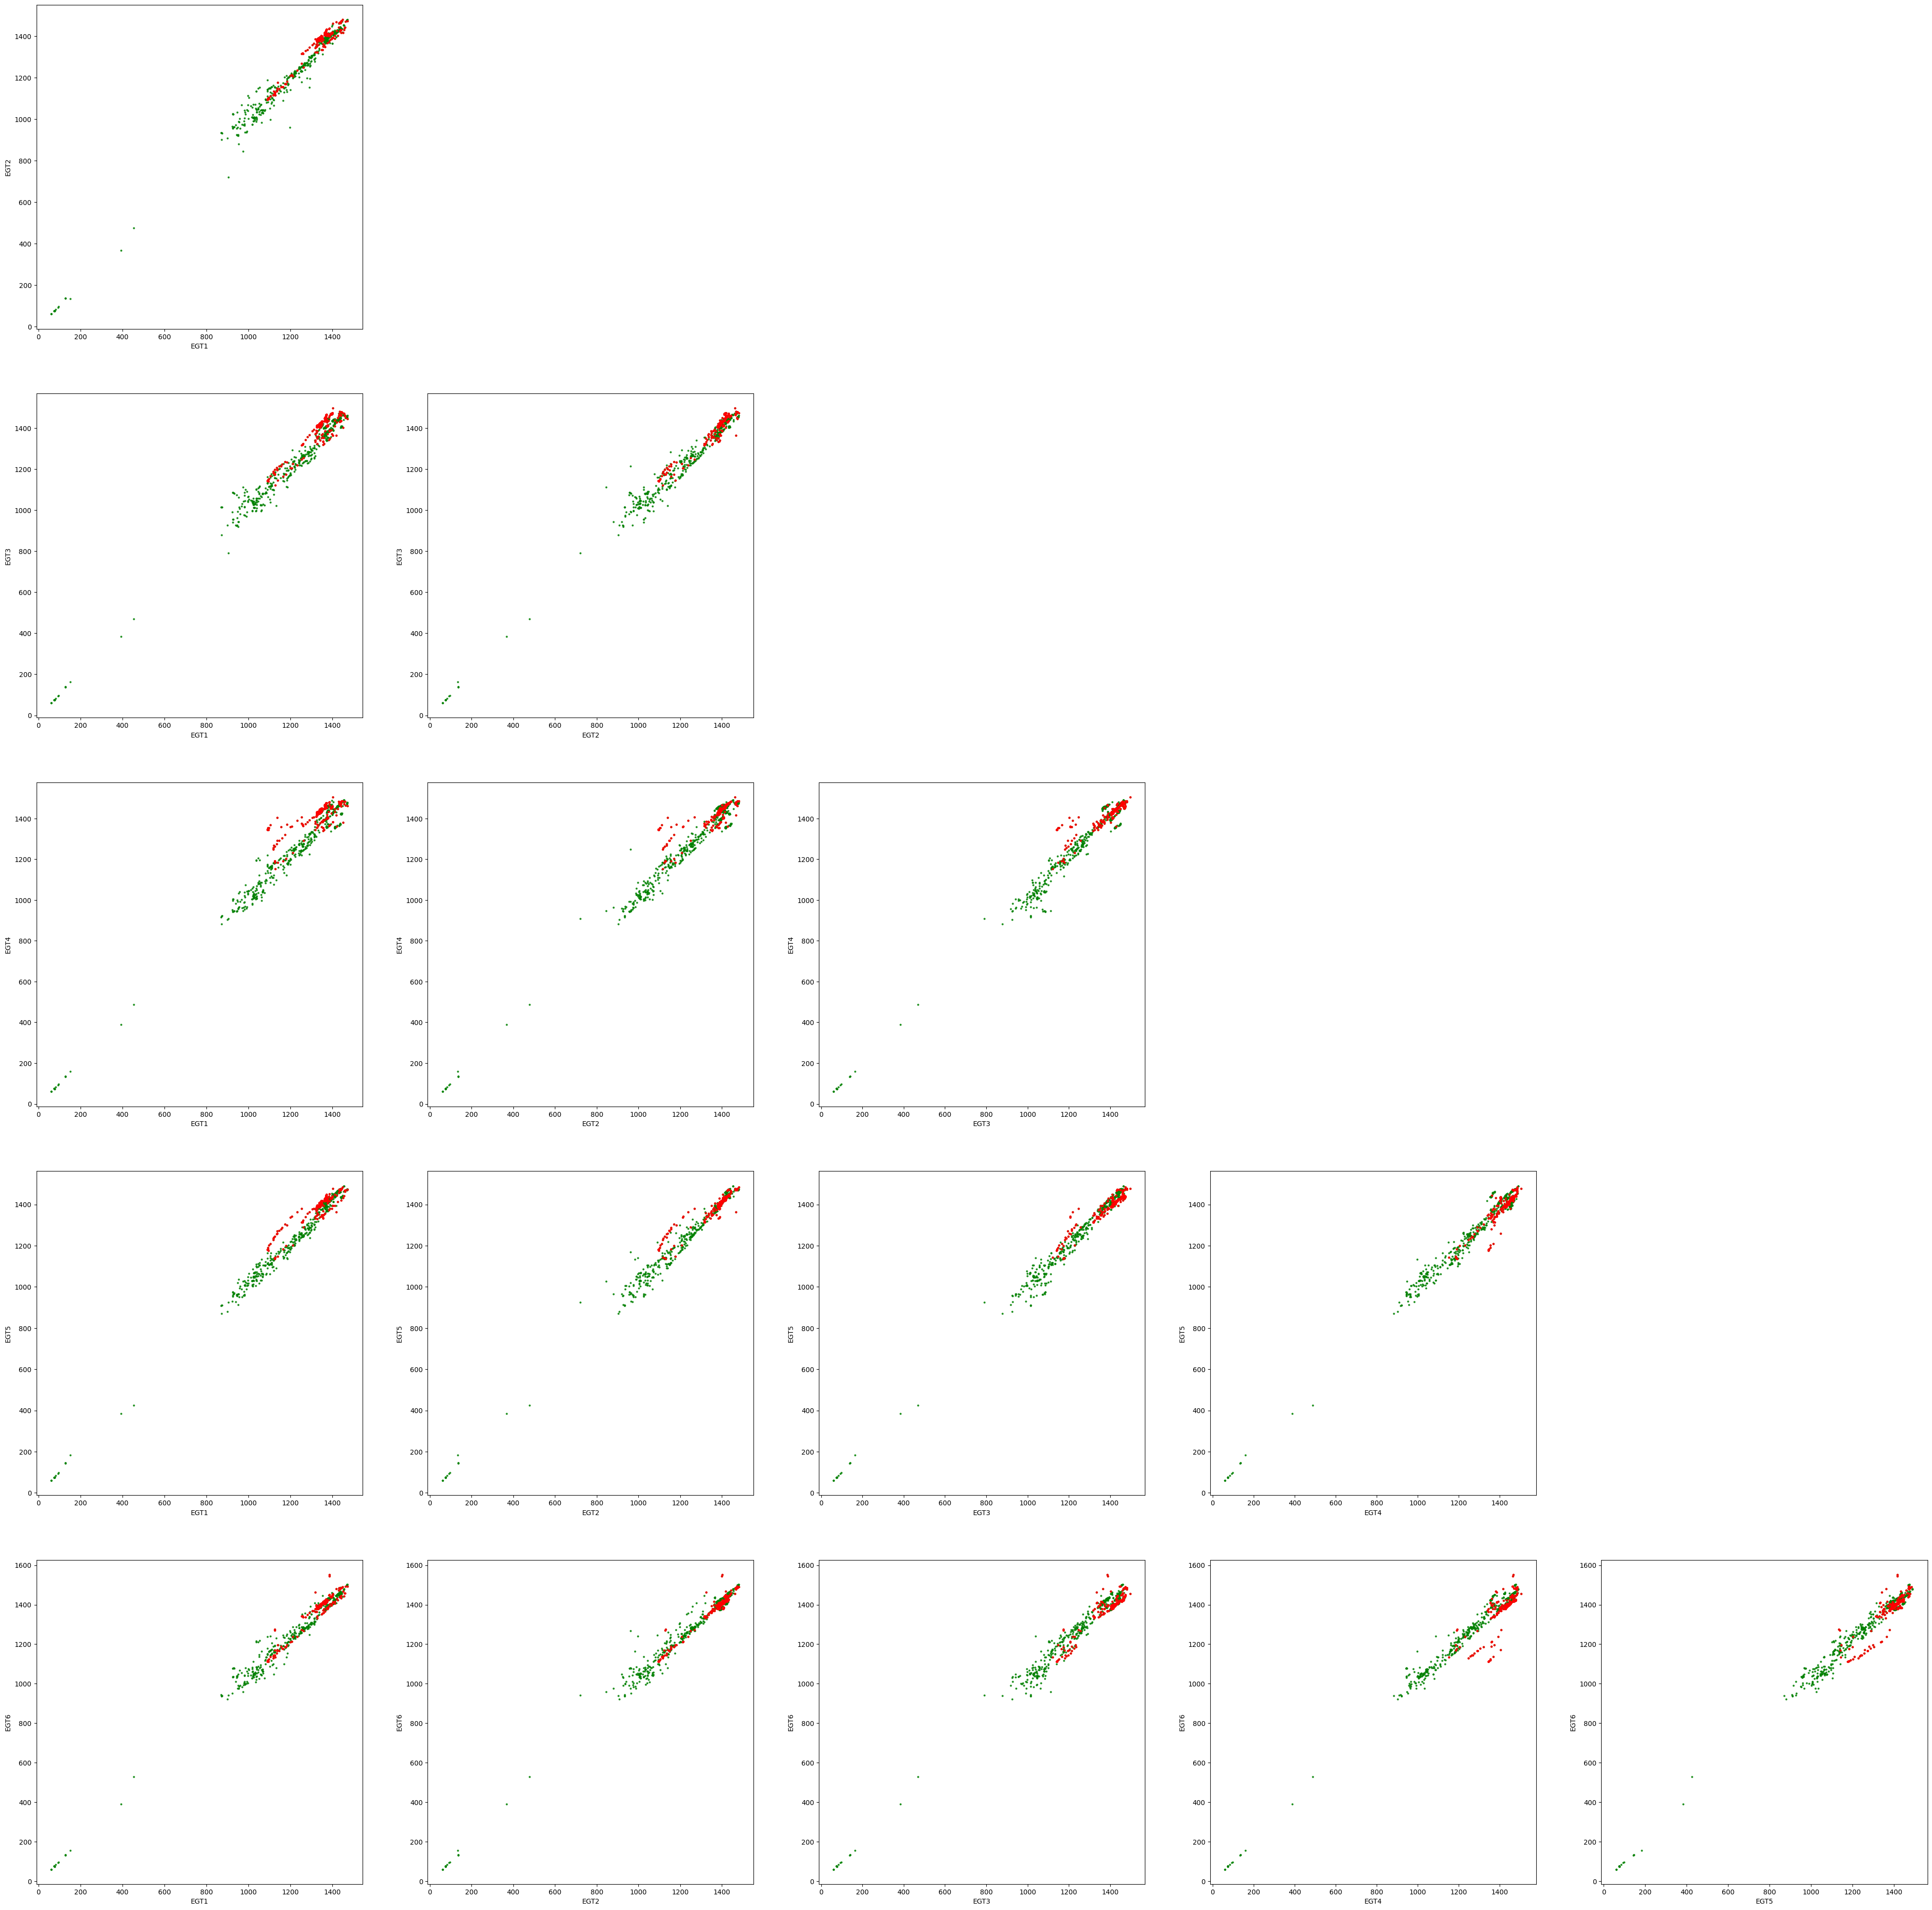

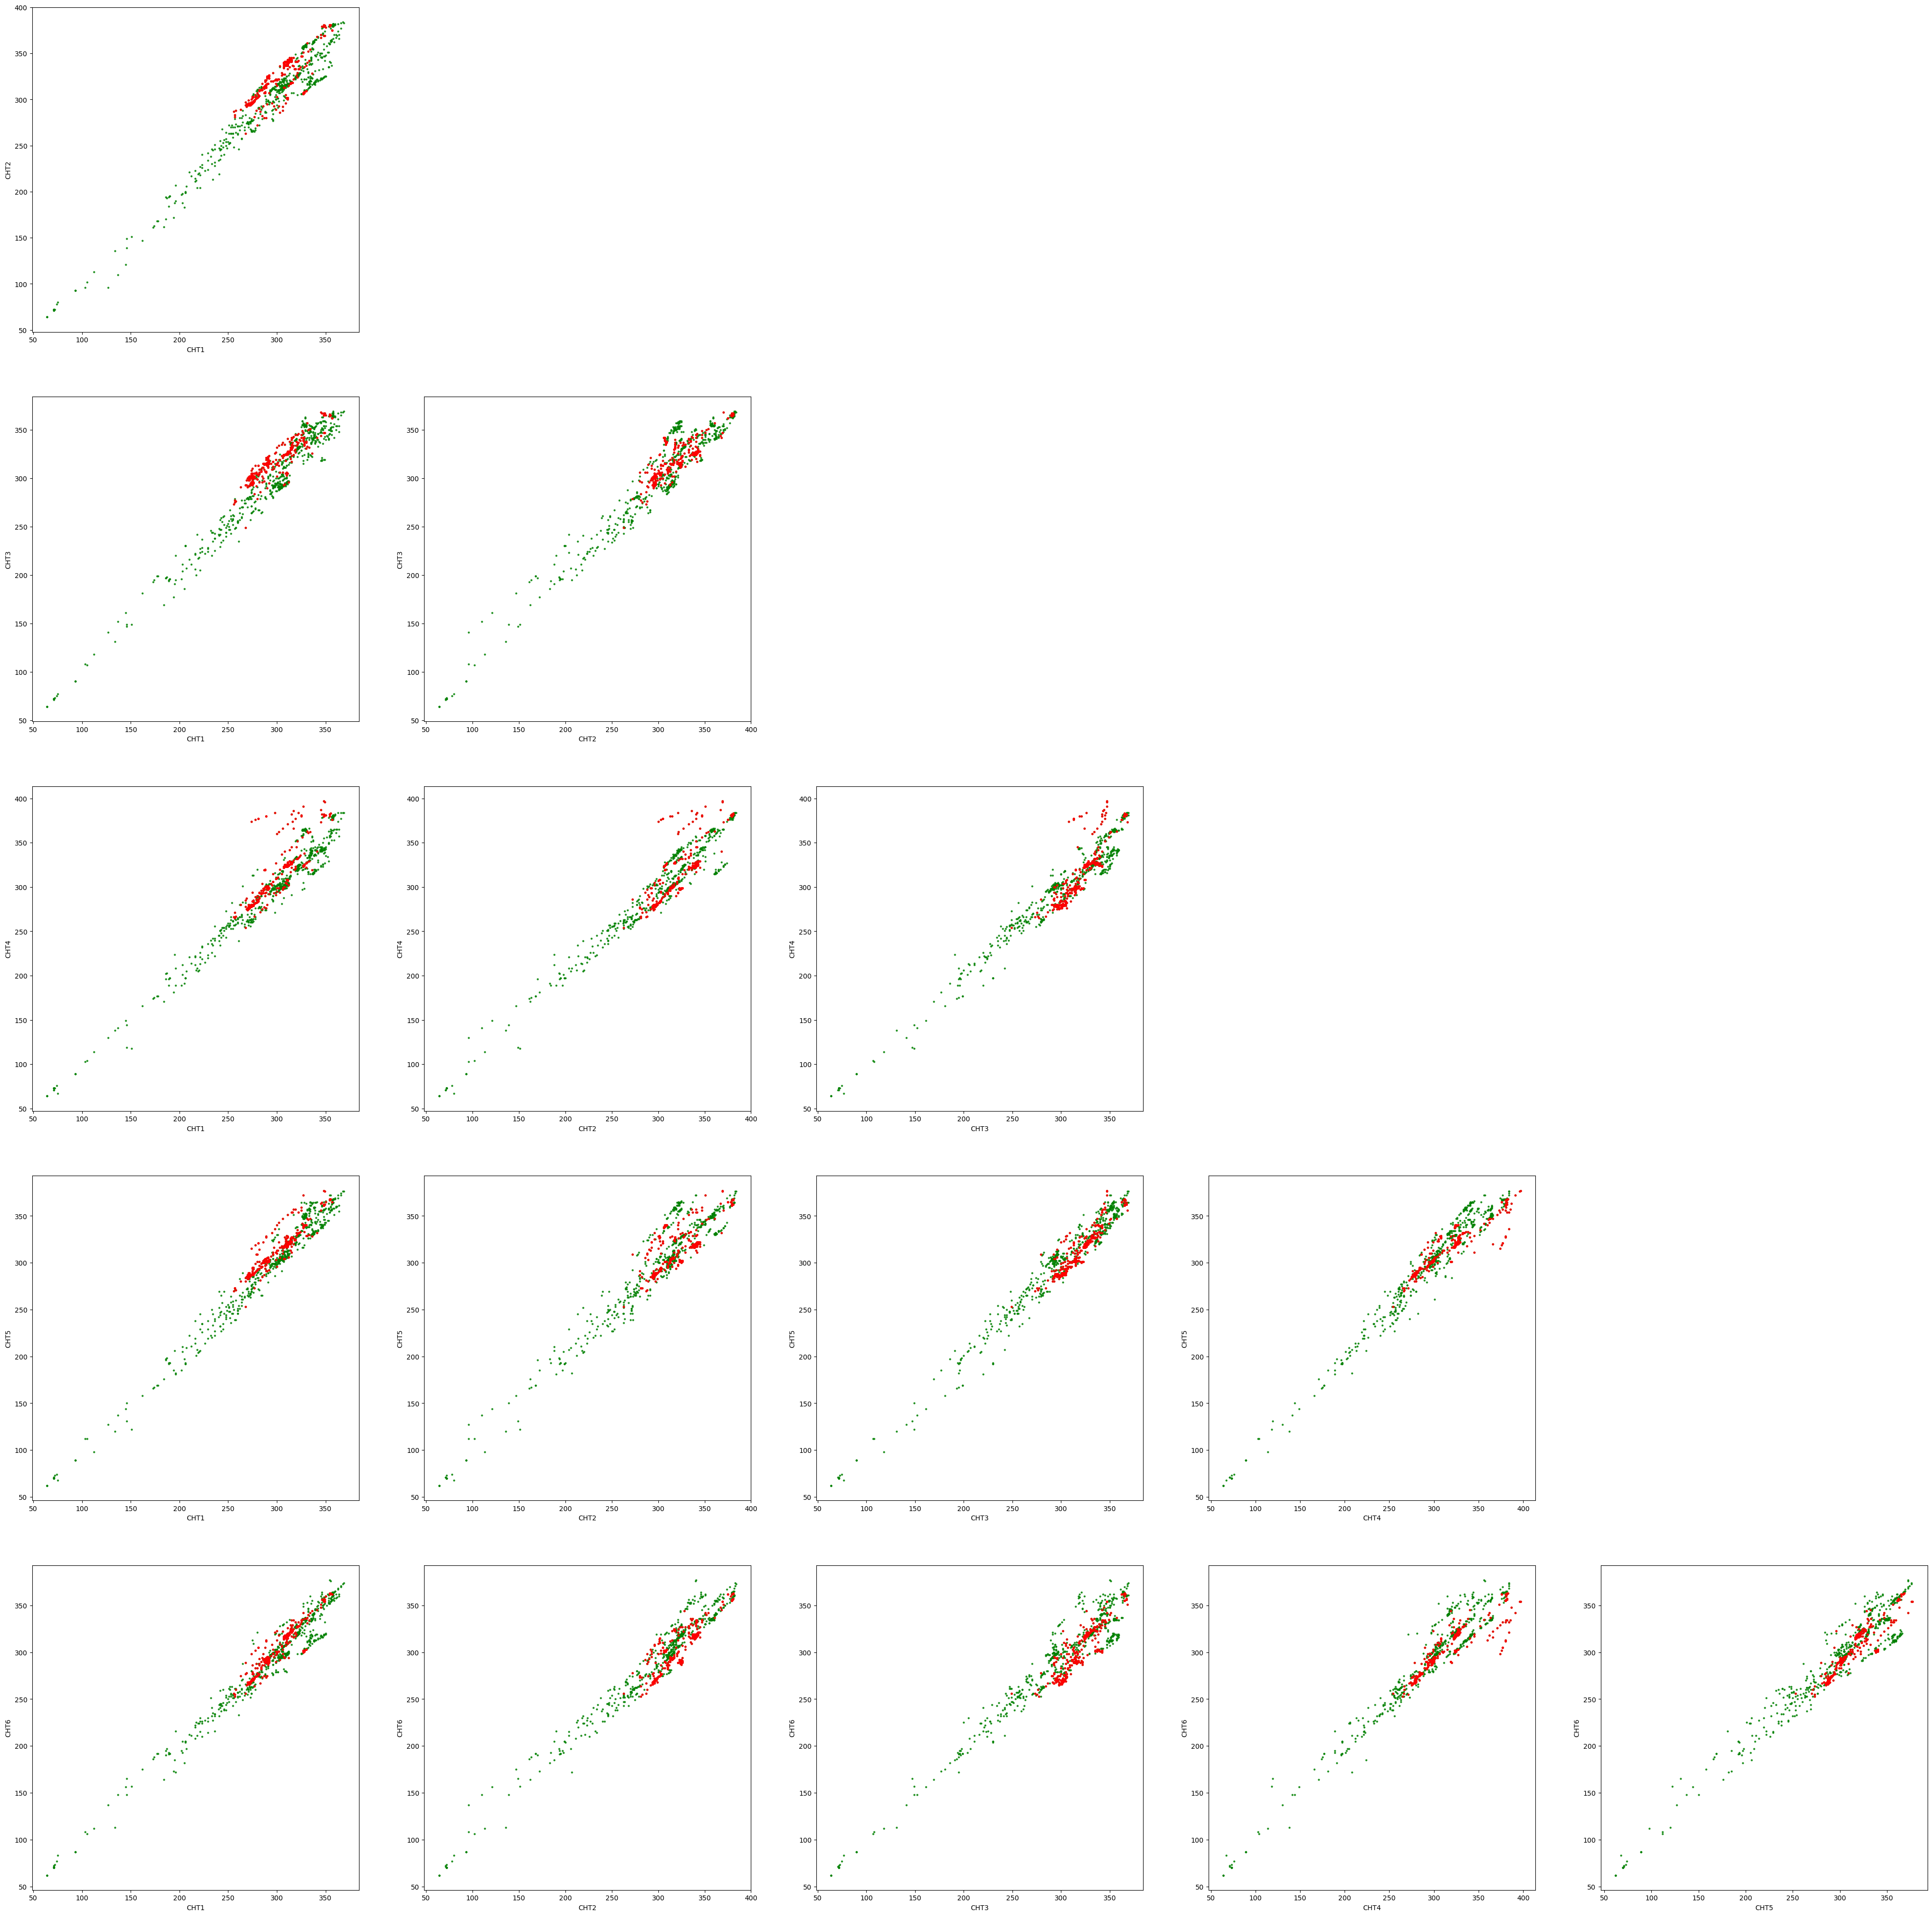

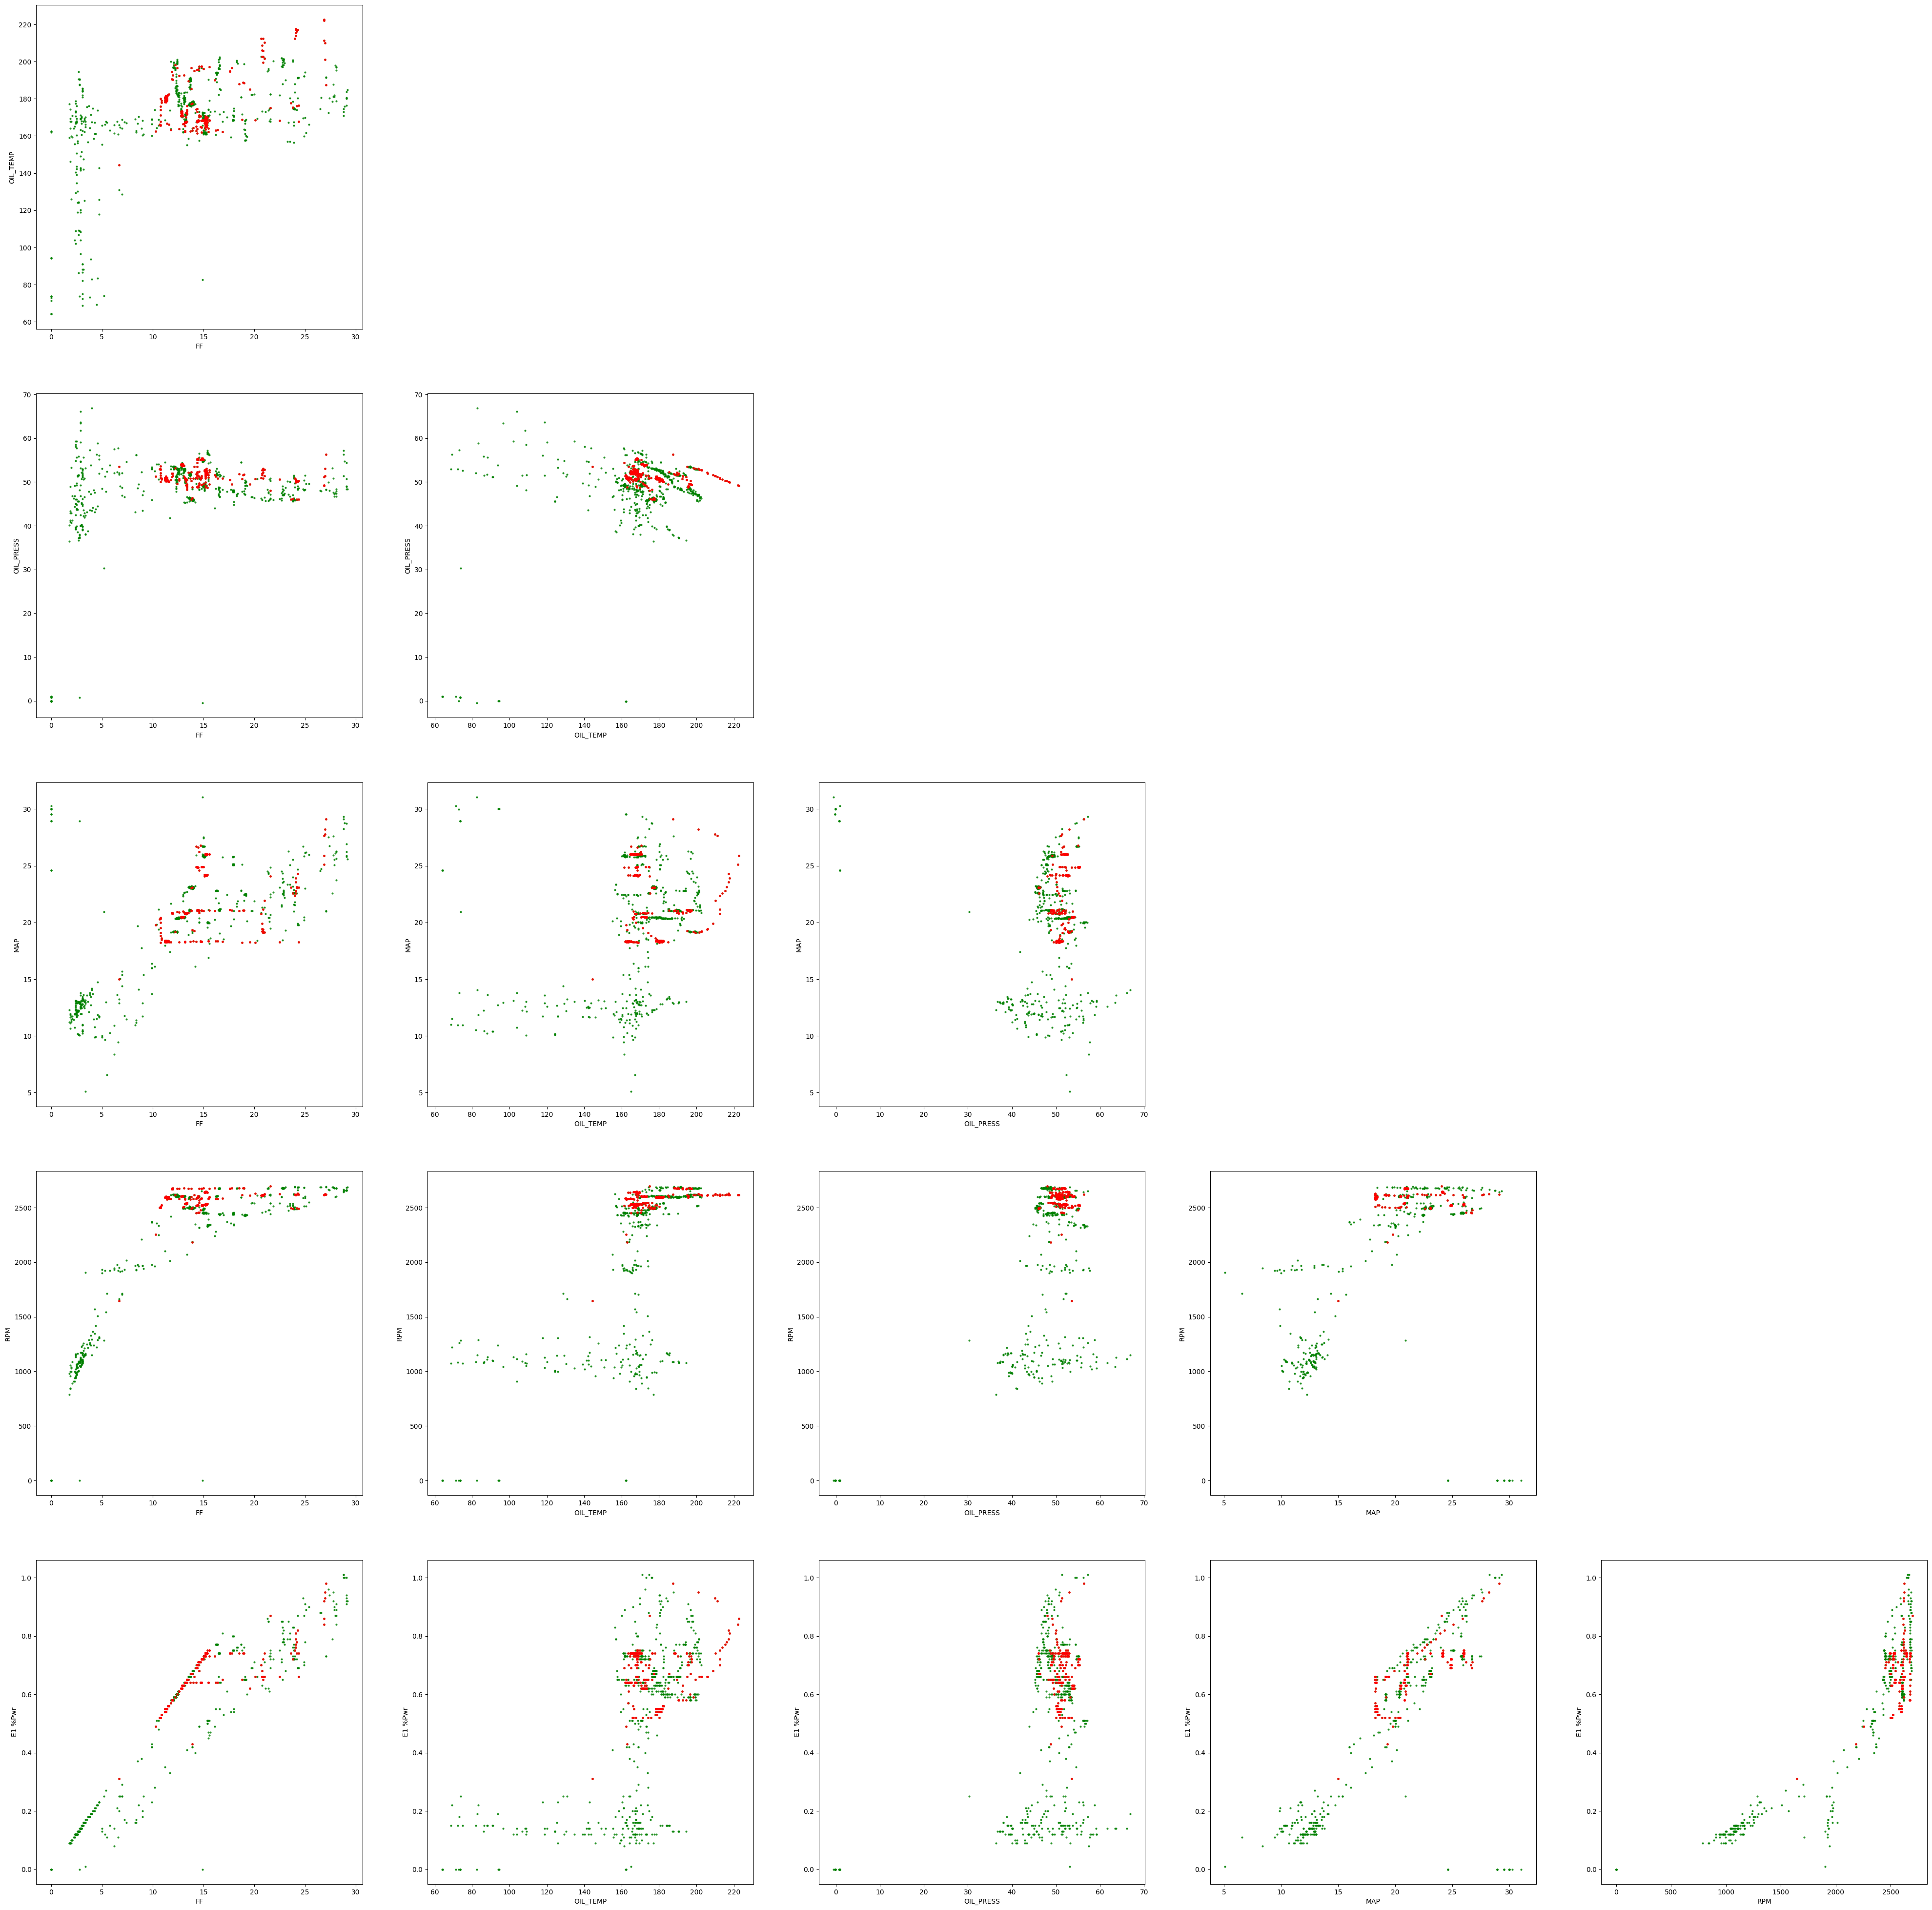

In [17]:
#@title Plot pair plots

observations = filtered_test_sample.sample(n = 1000)
plot_pair_plots(observations[['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'class_label']])
plot_pair_plots(observations[['CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6', 'class_label']])
plot_pair_plots(observations[[ 'FF', 'OIL_TEMP', 'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'class_label']])

#3 Define Anomaly Detectors

In [ ]:
#@title Reset and Parameterize Anomaly Detectors
ad_dict = {}
n_folds = 5
log_dir = "logs/nsnn2" #@param {type:"string"}


# Set up the logging directory.
!mkdir -p $log_dir

# Isolation Forest Parameters
iso_params = {}

# One-class SVM Parameters
ocsvm_params = {}

# Neg Sampling Random Forest Parameters
nsrf_params = {}

# Neg Sampling Neural Net Parameters
nsnn_params = {}

iso_params['n_estimators'] = 40
iso_params['max_samples'] = 0.1
iso_params['contamination'] = 0.05
iso_params['max_features'] = 0.44

ocsvm_params['kernel'] = 'rbf'
ocsvm_params['shrinking'] = True
ocsvm_params['nu'] = 0.04  # Contamination
ocsvm_params['gamma'] = 'scale'
ocsvm_params['coef0'] = 0.0

nsnn_params = {}

nsnn_params['sample_ratio']=5.0
nsnn_params['sample_delta']=0.01
nsnn_params['batch_size']=16
nsnn_params['steps_per_epoch']=32
nsnn_params['epochs']=2000
nsnn_params['dropout']=0.1
nsnn_params['layer_width']=64
nsnn_params['n_hidden_layers']=2
nsnn_params['learning_rate']=0.001
nsnn_params['patience']=40



madi_params = {}
madi_params['sample_ratio']=20.0
madi_params['sample_delta']=0.01
madi_params['batch_size']=32
madi_params['steps_per_epoch']=32
madi_params['epochs']=2000
madi_params['dropout']=0.2
madi_params['learning_rate']=0.0001
madi_params['patience']=40
madi_params['engine_performance_layers']=(128, 64)
madi_params['flight_performance_layers']=(128,  )
madi_params['auxiliary_feature_layers']=(128, 64 )
madi_params['joint_layers']=(128, )

In [ ]:
#@title sample_utils
#     Copyright 2020 Google LLC
#
#     Licensed under the Apache License, Version 2.0 (the "License");
#     you may not use this file except in compliance with the License.
#     You may obtain a copy of the License at
#
#         https://www.apache.org/licenses/LICENSE-2.0
#
#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.
"""Utilities to to generate or modify data samples."""

from typing import List, Dict

import numpy as np
import pandas as pd
import tensorflow as tf


class Variable(object):

  def __init__(self, index, name, mean, std):
    self.index = index
    self.mean = mean
    self.name = name
    self.std = std


def get_normalization_info(df: pd.DataFrame) -> Dict[str, Variable]:
  """Computes means, standard deviation to normalize a data frame.

  Any variable xxxx_validity is considered a boolean validity indicator
  for variable xxxx, and will not be normalized. A value of 1
  indicates the value xxxx is valid, and 0 indicates xxx is invalid.

  Args:
    df: Pandas dataframe with numeric feature data.

  Returns:
    A dict with Variable.name, Variable.
  """
  variables = {}
  for column in df:
    if not np.issubdtype(df[column].dtype, np.number):
      raise ValueError("The feature column %s is not numeric." % column)

    if column.endswith("_validity"):
      vmean = 0.0
      vstd = 1.0
    else:
      vmean = df[column].mean()
      vstd = df[column].std()

    variable = Variable(
        index=df.columns.get_loc(column),
        name=column,
        mean=vmean,
        std=vstd)
    variables[column] = variable
  return variables


def get_column_order(normalization_info: Dict[str, Variable]) -> List[str]:
  """Returns a list of column names, as strings, in model order."""
  return [
      var.name
      for var in sorted(normalization_info.values(), key=lambda var: var.index)
  ]


def normalize(df: pd.DataFrame,
              normalization_info: Dict[str, Variable]) -> pd.DataFrame:
  """Normalizes an input Dataframe of features.

  Args:
    df: Pandas DataFrame of M rows with N real-valued features
    normalization_info: dict of name, variable types containing mean, and std.

  Returns:
    Pandas M x N DataFrame with normalized features.
  """

  df_norm = pd.DataFrame()
  for column in get_column_order(normalization_info):
    if normalization_info[column].std == 0.0:
      df_norm[column] = 0.0
    else:
      df_norm[column] = (df[column] - normalization_info[column].mean
                        ) / normalization_info[column].std
  return df_norm


def denormalize(df_norm: pd.DataFrame,
                normalization_info: Dict[str, Variable]) -> pd.DataFrame:
  """Reverts normalization an input Dataframe of features.

  Args:
    df_norm: Pandas DataFrame of M rows with N real-valued normalized features
    normalization_info: dict of name, variable types containing mean, and std.

  Returns:
    Pandas M x N DataFrame with denormalized features.
  """
  df = pd.DataFrame()

  for column in get_column_order(normalization_info):
    if normalization_info[column].std == 0.0:
      df[column] = normalization_info[column].mean
    else:
      df[column] = df_norm[column] * normalization_info[
          column].std + normalization_info[column].mean
  return df


def write_normalization_info(normalization_info: Dict[str, Variable],
                             filename: str):
  """Writes variable normalization info to CSV."""

  def to_df(normalization_info):
    df = pd.DataFrame(columns=["index", "mean", "std"])
    for variable in normalization_info:
      df.loc[variable] = [
          normalization_info[variable].index, normalization_info[variable].mean,
          normalization_info[variable].std
      ]
    return df

  with tf.io.gfile.GFile(filename, "w") as csv_file:
    to_df(normalization_info).to_csv(csv_file, sep="\t")


def read_normalization_info(
    filename: str) -> Dict[str, Variable]:
  """Reads variable normalization info from CSV."""

  def from_df(df):
    normalization_info = {}
    for name, row in df.iterrows():
      normalization_info[name] = Variable(
          row["index"], name, row["mean"], row["std"])
    return normalization_info

  normalization_info = {}
  if not tf.io.gfile.exists(filename):
    raise AssertionError("{} does not exist".format(filename))
  with tf.io.gfile.GFile(filename, "r") as csv_file:
    df = pd.read_csv(csv_file, header=0, index_col=0, sep="\t")
    normalization_info = from_df(df)
  return normalization_info


def get_neg_sample(pos_sample: pd.DataFrame,
                   n_points: int,
                   do_permute: bool = False,
                   delta: float = 0.0) -> pd.DataFrame:
  """Creates a negative sample from the cuboid bounded by +/- delta.

  Where, [min - delta, max + delta] for each of the dimensions.
  If do_permute, then rather than uniformly sampling, simply
  randomly permute each dimension independently.
  The positive sample, pos_sample is a pandas DF that has a column
  labeled 'class_label' where 1.0 indicates Normal, and
  0.0 indicates anomalous.

  Args:
    pos_sample: DF with numeric dimensions
    n_points: number points to be returned
    do_permute: permute or sample
    delta: fraction of [max - min] to extend the sampling.

  Returns:
    A dataframe  with the same number of columns, and a label column
    'class_label' where every point is 0.
  """
  df_neg = pd.DataFrame()

  pos_sample_n = pos_sample.sample(n=n_points, replace=True)

  for field_name in list(pos_sample):

    if field_name == "class_label":
      continue

    if do_permute:
      df_neg[field_name] = np.random.permutation(
          np.array(pos_sample_n[field_name]))

    else:
      low_val = min(pos_sample[field_name])
      high_val = max(pos_sample[field_name])
      delta_val = high_val - low_val
      df_neg[field_name] = np.random.uniform(
          low=low_val - delta * delta_val,
          high=high_val + delta * delta_val,
          size=n_points)

  df_neg["class_label"] = [0 for _ in range(n_points)]
  return df_neg


def apply_negative_sample(positive_sample: pd.DataFrame, sample_ratio: float,
                          sample_delta: float) -> pd.DataFrame:
  """Returns a dataset with negative and positive sample.

  Args:
    positive_sample: actual, observed sample where each col is a feature.
    sample_ratio: the desired ratio of negative to positive points
    sample_delta: the extension beyond observed limits to bound the neg sample

  Returns:
    DataFrame with features + class label, with 1 being observed and 0 negative.
  """

  positive_sample["class_label"] = 1
  n_neg_points = int(len(positive_sample) * sample_ratio)
  negative_sample = get_neg_sample(
      positive_sample, n_neg_points, do_permute=False, delta=sample_delta)
  training_sample = pd.concat([positive_sample, negative_sample],
                              ignore_index=True,
                              sort=True)
  return training_sample.reindex(np.random.permutation(training_sample.index))


def get_pos_sample(df_input: pd.DataFrame, n_points: int) -> pd.DataFrame:
  """Draws n_points from the data sample, and adds a class_label column."""
  df_pos = df_input.sample(n=n_points)
  df_pos["class_label"] = 1
  return df_pos


def get_train_data(input_df: pd.DataFrame,
                   n_points: int,
                   sample_ratio: float = 1.0,
                   do_permute: bool = True):
  """Generates a test and train data set for buidlings a test model.

  Args:
    input_df: dataframe containing observed, real-valued data, where each field
      is a dimension.
    n_points: total number points to be returned (positive and negative)
    sample_ratio: rtio, neg sample / pos sample sizes (e.g., 2 = means 2x neg
      points as pos)
    do_permute: False, uniformly sample; True. sample positive and permute cols

  Returns:
    x: Dataframe with d-Dim cols and, n_points rows
    y: class labels, with 1 = Normal/positive and 0 = Anomalous/negative class
  """

  # Create the positive class sample, with mean at the origin and a
  # rotated covariance matrix.
  n_pos = int(n_points / (sample_ratio + 1.0))
  n_neg = n_points - n_pos
  # Gather a random subsample of length n, as the positive set.
  df_pos = get_pos_sample(input_df, n_pos)

  if sample_ratio > 0.0:
    # Generate a random negative sample.
    df_neg = get_neg_sample(df_pos, n_neg, do_permute)

    # Combine both, randomize and split.
    df_combined = pd.concat([df_pos, df_neg], ignore_index=True)
  else:
    df_combined = df_pos.sample(n=n_points)
  df_combined = df_combined.iloc[np.random.permutation(len(df_combined))]

  # Separate the labels, and remove the column.
  y = df_combined["class_label"]
  x = df_combined.drop(columns=["class_label"])
  return x, y


def get_pos_sample_synthetic(mean: float, cov: float,
                             n_points: int) -> pd.DataFrame:
  """Generates a positive sample from a Gaussian distribution with n_points.

  Args:
    mean: d-dimensional vector of mean values.
    cov: dxd dimensional covariance matrix.
    n_points: Number of points to return.

  Returns:
    DataFrame with cols x001...x[d] and n_points rows drawn from Guassian with
    mean and cov.
  """

  pos_mat = np.random.multivariate_normal(mean, cov, n_points).T
  df_pos = pd.DataFrame({"class_label": [1 for _ in range(n_points)]})

  for i in range(pos_mat.shape[0]):
    df_pos["x%03d" % (i + 1)] = pos_mat[i]
  return df_pos

In [ ]:
#@title NS-NN (MADI)
#     Copyright 2020 Google LLC
#
#     Licensed under the Apache License, Version 2.0 (the "License");
#     you may not use this file except in compliance with the License.
#     You may obtain a copy of the License at
#
#         https://www.apache.org/licenses/LICENSE-2.0
#
#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitansnn_paramstions under the License.
"""Anomaly Detector based on Negative Sampling Neural Network (NS-NN)."""


_SHUFFLE_BUFFERSIZE = 500
_MODEL_FILENAME = 'model-multivariate-ad'
_NORMALIZATION_FILENAME = 'normalization_info'

class NegativeSamplingDataset:

  def __init__(self, sample_ratio, batch_size, sample_delta, x_train, column_order):
    self._sample_ratio = sample_ratio
    self._batch_size = batch_size
    self._x_train = x_train.sample(frac =1)
    self._sample_delta = sample_delta
    self._column_order = column_order

  def __len__(self):
    return (self._batch_size * (1 + self._sample_ratio), len(self._column_order) )

  def __call__(self):
    mbatch =  self._x_train.sample(n = self._batch_size, replace = True)
    training_sample = apply_negative_sample(
        positive_sample=mbatch,
        sample_ratio=self._sample_ratio,
        sample_delta=self._sample_delta)
    x = np.float32(np.matrix(training_sample[self._column_order]))
    y = np.float32(np.array(training_sample['class_label']))
    yield x, y


  def on_epoch_end(self):
    print('epoch ended')


class NegativeSamplingNeuralNetworkAD(BaseAnomalyDetectionAlgorithm):
  """Anomaly detection using negative sampling and a neural net classifier."""

  def __init__(self,
               sample_ratio: float,
               sample_delta: float,
               batch_size: int,
               steps_per_epoch: int,
               epochs: int,
               dropout: float,
               learning_rate: float,
               layer_width: int,
               n_hidden_layers: int,
               log_dir: str,
               tpu_worker: Optional[str] = None,
               patience: int = 10):
    self._sample_ratio = sample_ratio
    self._sample_delta = sample_delta
    self._model = None
    self._history = None
    self._steps_per_epoch = steps_per_epoch
    self._epochs = epochs
    self._dropout = dropout
    self._layer_width = layer_width
    self._n_hidden_layers = n_hidden_layers
    self._log_dir = log_dir
    self._tpu_worker = tpu_worker
    self._batch_size = batch_size
    self._normalization_info = None
    self._learning_rate = learning_rate
    self._patience = patience
    logging.info('TensorFlow version %s', tf.version.VERSION)

    # Especially with TPUs, it's useful to destroy the current TF graph and
    # creates a new one before getting started.
    tf.keras.backend.clear_session()

  def train_model(self, x_train: pd.DataFrame) :
    """Train a new model and report the loss and accuracy.

    Args:
      x_train: dataframe with dimensions as columns.
    """
    self._normalization_info = get_normalization_info(x_train)
    column_order = get_column_order(self._normalization_info)
    normalized_x_train = normalize(x_train,
                                                self._normalization_info)

    n_points = len(normalized_x_train)
    train_points = int(0.8 * n_points)
    train_ngen = NegativeSamplingDataset(sample_ratio = self._sample_ratio,
                                         batch_size=self._batch_size,
                                         sample_delta=self._sample_delta,
                                         x_train=normalized_x_train.iloc[:train_points],
                                         column_order=column_order)
    train_dataset = tf.data.Dataset.from_generator(
        train_ngen,
        output_signature=(
            tf.TensorSpec(shape=(None, len(column_order)), dtype=tf.float32),
            tf.TensorSpec(shape=(None), dtype=tf.float32)))

    val_ngen = NegativeSamplingDataset(sample_ratio = min(10.0, self._sample_ratio),
                                         batch_size=self._batch_size,
                                         sample_delta=self._sample_delta,
                                         x_train=normalized_x_train.iloc[train_points:],
                                         column_order=column_order)
    val_dataset = tf.data.Dataset.from_generator(
        val_ngen,
        output_signature=(
            tf.TensorSpec(shape=(None, len(column_order)), dtype=tf.float32),
            tf.TensorSpec(shape=(None), dtype=tf.float32)))





    if self._tpu_worker:
      resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
          self._tpu_worker)
      tf.contrib.distribute.initialize_tpu_system(resolver)
      strategy = tf.contrib.distribute.TPUStrategy(resolver)
      with strategy.scope():
        self._model = self._get_model(len(column_order), self._dropout,
                                      self._layer_width, self._n_hidden_layers)
    else:
      self._model = self._get_model(len(column_order), self._dropout,
                                    self._layer_width, self._n_hidden_layers)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self._patience)

    return self._model.fit(
        train_dataset,
        # steps_per_epoch=self._steps_per_epoch,
        verbose=1,
        epochs=self._epochs,
        validation_data = val_dataset,
        batch_size = self._batch_size,
        callbacks=[
            # tf.keras.callbacks.TensorBoard(
            #     log_dir=self._log_dir,
            #     histogram_freq=1,
            #     write_graph=False,
            #     write_images=False),
            early_stopping
        ]
        )

  def predict(self, sample_df: pd.DataFrame) -> pd.DataFrame:
    """Given new data, predict the probability of being positive class.

    Args:
      sample_df: dataframe with features as columns, same as train().

    Returns:
      DataFrame as sample_df, with colum 'class_prob', prob of Normal class.
    """

    sample_df_normalized = normalize(sample_df,
                                                  self._normalization_info)
    column_order = get_column_order(self._normalization_info)
    x = np.float32(np.matrix(sample_df_normalized[column_order]))
    y_hat = self._model.predict(x, verbose=1, steps=1)
    sample_df['class_prob'] = y_hat
    return sample_df

  def _get_model(self, input_dim: int, dropout: float, layer_width: int,
                 n_hidden_layers: int) -> tf.keras.Sequential:
    """Creates a Neural Network model for Anomaly Detection.

    Creates a simple stack of dense/dropout layers with equal width.

    Args:
      input_dim: width of the input layer
      dropout: dropout probability for each hidden layer
      layer_width: hidden layer width
      n_hidden_layers: number of hidden layers

    Returns:
      tf.keras.Sequential model.
    """
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            layer_width, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))

    for _ in range(n_hidden_layers):
      model.add(tf.keras.layers.Dense(layer_width, activation='relu'))
      model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.RMSprop(
      learning_rate=self._learning_rate,
      rho=0.9,
      momentum=0.0,
      epsilon=1e-07,
      centered=False,
      weight_decay=None,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=False,
      ema_momentum=0.99,
      ema_overwrite_frequency=100,
      jit_compile=True,
      name="RMSprop")

    def weighted_binary_crossentropy_loss_function(y_true, y_pred):
      w_1 = 1.0
      w_0 = 1.0
      y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      term_0 = (1 - y_true) * tf.keras.backend.log(1 - y_pred + tf.keras.backend.epsilon())  * w_0
      term_1 = y_true * tf.keras.backend.log(y_pred + tf.keras.backend.epsilon()) * w_1
      return -tf.keras.backend.mean(term_0 + term_1, axis=0)



    model.compile(
        loss=weighted_binary_crossentropy_loss_function,
        optimizer=opt,
        metrics=[tf.keras.metrics.binary_accuracy])
    return model

  def save_model(self, model_dir: str) -> None:
    """Saves the trained AD model to the model directory model_dir."""
    model_file_path = os.path.join(model_dir, _MODEL_FILENAME)
    tf.keras.models.save_model(self._model, model_file_path, overwrite=True)
    logging.info('Sucessfully wrote the model to %s', model_file_path)
    normalization_file_path = os.path.join(model_dir, _NORMALIZATION_FILENAME)
    write_normalization_info(self._normalization_info,
                                          normalization_file_path)
    logging.info('Sucessfully saved normalization info to %s',
                 normalization_file_path)

  def load_model(self, model_dir: str) -> None:
    """Loads the trained AD model from the model directory model_dir."""
    model_file_path = os.path.join(model_dir, _MODEL_FILENAME)
    self._model = tf.keras.models.load_model(model_file_path)
    logging.info('Successfully loaded model from %s', model_file_path)
    normalization_file_path = os.path.join(model_dir, _NORMALIZATION_FILENAME)
    self._normalization_info = read_normalization_info(
        normalization_file_path)
    logging.info('Sucessfully read normalization info from %s',
                 normalization_file_path)

In [ ]:
#@title Add in Negative Sampling Neural Net (ns-nn)
ad_dict['madi'] = [NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        learning_rate = nsnn_params['learning_rate'],
        log_dir=log_dir,
        patience = nsnn_params['patience']
        ) for _ in range(n_folds)]

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['madi']


In [ ]:
#@title Heuristics AD
_AD_HEURSITICS_DICT = {
      'EGT': [1000, 1300, 1600, 200],
      'EGT_ROC': [-100, 0, 200, 50],
      'CHT': [70, 300, 400, 40],
      'CHT_ROC': [-75, 10, 75, 20],
      'volt1': [24, 28, 30, 2],
      'volt1_ROC': [-5, 0, 5, 1],
      'volt2': [24, 28, 30, 2],
      'volt2_ROC': [-5, 0, 5, 1],
      'amp1': [-2, 0, 2, 1],
      'amp1_ROC': [-2, 0, 2, 1],
      'FF': [0, 12.5, 30, 7],
      'FF_ROC': [-6, 0, 10, 0.25],
      'OIL_TEMP': [50, 175, 200, 20],
      'OIL_TEMP_ROC': [-75, 5, 75, 10],
      'OIL_PRESS': [20, 50, 60, 10],
      'OIL_PRESS_ROC': [-5, 0, 20, 2],
      'MAP': [10, 25, 30, 5],
      'MAP_ROC': [-10, 0, 30, 2],
      'RPM': [800, 2200, 2700, 600],
      'RPM_ROC': [-300, 0, 300, 25],
      'E1 %Pwr': [0, 0.6, 1, 0.25],
      'E1 %Pwr_ROC': [-0.1, 0, 0.3, 0.01],
}

from enum import Enum
from typing import Mapping, Sequence
from scipy import stats

class Heuristic(Enum):
  MIN_MAX = 1
  UNIVARIATE_NORMAL = 2

class HeuristicAnomalyDetectionAlgorithm(BaseAnomalyDetectionAlgorithm):


  def __init__(self, ad_heuristics_dict: Mapping[str, Sequence[float]], heuristic: Heuristic):

    # feature: [MIN, MEAN, MAX, STANDARD DEVIATION]
    self._ad_heuristics_dict = ad_heuristics_dict
    self._heuristic = heuristic


  def train_model(self, x_train: pd.DataFrame) -> None:
    """Trains the model on a training set."""
    pass

  def _min_max_check(self, example: Mapping[str, float]) -> float:
    """Returns 1.0 if withing min/max thresholds for all fetures, and 0 otw."""

    for feature in example:

      if feature.startswith('EGT'):
        hfeature = 'EGT'
      elif feature.startswith('CHT'):
        hfeature = 'CHT'
      else:
        hfeature = feature

      if hfeature not in self._ad_heuristics_dict:
        continue

      if example[feature] < self._ad_heuristics_dict[hfeature][0] or example[feature] > self._ad_heuristics_dict[hfeature][2]:
        return 0.0
    return 1.0

  def _normal_check(self, example: Mapping[str, float]) -> float:
    """Performs a two-sided check with Normal distribution."""

    for feature in example:

      if feature.startswith('EGT'):
        hfeature = 'EGT'
      elif feature.startswith('CHT'):
        hfeature = 'CHT'
      else:
        hfeature = feature

      if hfeature not in self._ad_heuristics_dict:
        continue

      abs_z_scores = []
      # z = (x - mu) / sigma
      z = (example[feature] - self._ad_heuristics_dict[hfeature][1])/self._ad_heuristics_dict[hfeature][3]

      abs_z_scores.append(abs(z))

      p_scores = stats.norm.sf(abs_z_scores)*2

    return min(p_scores)


  def predict(self, sample_df: pd.DataFrame) -> pd.DataFrame:
    """Predicts with the model on a test set."""
    preds = []
    sample = sample_df.copy()
    for ix, row in sample.iterrows():
      example = row.to_dict()
      if self._heuristic == Heuristic.MIN_MAX:
        preds.append(self._min_max_check(example))
      else:
        preds.append(self._normal_check(example))
    sample['class_prob'] = preds
    return sample


# heuristic_ad = HeuristicAnomalyDetectionAlgorithm(ad_heuristics_dict=_AD_HEURSITICS_DICT, heuristic = Heuristic.UNIVARIATE_NORMAL)

ad_dict['heuristic_minmax'] = [HeuristicAnomalyDetectionAlgorithm(ad_heuristics_dict=_AD_HEURSITICS_DICT, heuristic = Heuristic.MIN_MAX) for _ in range(n_folds)]
ad_dict['univariate_normal'] = [HeuristicAnomalyDetectionAlgorithm(ad_heuristics_dict=_AD_HEURSITICS_DICT, heuristic = Heuristic.UNIVARIATE_NORMAL) for _ in range(n_folds) ]
print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['madi', 'heuristic_minmax', 'univariate_normal']


In [ ]:
#@title Isolation Forest Anomaly Detector (iso)
ad_dict['iso'] =[IsolationForestAd(n_estimators=iso_params['n_estimators'],
                               max_samples=iso_params['max_samples'],
                               contamination=iso_params['contamination'],
                               max_features=iso_params['max_features'],
                               bootstrap=False, n_jobs=None,
                               random_state=None, verbose=0) for _ in range(n_folds) ]

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['madi', 'heuristic_minmax', 'univariate_normal', 'iso']


In [ ]:
#@title One-Class SVM (oc-svm)
import sklearn.svm
from madi.detectors.base_detector import BaseAnomalyDetectionAlgorithm
from typing import Dict
import madi.utils.sample_utils as sample_utils


class OneClassSVMAd(sklearn.svm.OneClassSVM, BaseAnomalyDetectionAlgorithm):
  """Wrapper class around the scikit-learn OC-SVM implementation."""

  def __init__(self, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001,
               nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1):
    """Constructs a OC-SVM Anomaly Detector.

    Args:
      *args: See the klearn.svm.OneClassSVM.
      **kwargs: See the klearn.svm.OneClassSVM.
    """
    super(OneClassSVMAd, self).__init__(kernel=kernel, degree=degree, gamma=gamma,
                                        coef0=coef0, tol=tol, nu=nu, shrinking=shrinking,
                                        cache_size=cache_size, verbose=verbose, max_iter=max_iter)
    self._normalization_info = None

  def train_model(self, x_train: pd.DataFrame) -> None:
    """Trains a OC-SVM Anomaly detector using the positive sample.

    Args:
      x_train: training sample, with numeric feature columns.
    """
    self._normalization_info = sample_utils.get_normalization_info(x_train)
    column_order = sample_utils.get_column_order(self._normalization_info)
    normalized_x_train = sample_utils.normalize(x_train[column_order],
                                                self._normalization_info)

    super(OneClassSVMAd, self).fit(X=normalized_x_train)

  def predict(self, sample_df: pd.DataFrame) -> pd.DataFrame:
    """Performs anomaly detection on a new sample.

    Args:
      sample_df: dataframe with the new datapoints.

    Returns:
      original dataframe with a new column labled 'class_prob' as 1.0
      for normal to 0.0 for anomalous.
    """
    sample_df_normalized = sample_utils.normalize(sample_df,
                                                  self._normalization_info)
    column_order = sample_utils.get_column_order(self._normalization_info)
    x_test = np.float32(np.array(sample_df_normalized[column_order]))
    preds = super(OneClassSVMAd, self).predict(x_test)
    sample_df['class_prob'] = np.where(preds == -1, 0, preds)
    return sample_df

ad_dict['oc-svm'] = [OneClassSVMAd(
    kernel=ocsvm_params['kernel'],
    degree=3,
    gamma=ocsvm_params['gamma'],
    coef0=ocsvm_params['coef0'],
    tol=0.001,
    nu=ocsvm_params['nu'],
    shrinking=ocsvm_params['shrinking'],
    cache_size=200,
    verbose=False,
    max_iter=-1) for _ in range(n_folds) ]

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['madi', 'heuristic_minmax', 'univariate_normal', 'iso', 'oc-svm']


In [ ]:
#@title Execute Trial

from typing import Dict
eval_only_no_train = False #@param {type:"boolean"}

def fold_sample(sample: pd.DataFrame, n_folds: int = 2) ->  List[Dict[str, pd.DataFrame]]:
  """Splits a sample into N folds.

  Args:
    sample: training/test sample to be folded.
  """
  sample = shuffle(sample)

  folds = []
  # Split into train and test folds, and assign to list called folds.
  for training_sample_idx, test_sample_idx in KFold(n_splits=5).split(sample):
    test_sample = sample.iloc[test_sample_idx]
    training_sample = sample.iloc[training_sample_idx]
    folds.append({"train": training_sample, "test": test_sample})
  return folds


def plot_auc(ad_results: Dict[str, Dict[str, Dict[str, np.array]]],
             experiment_name: str):
  """Plots the ROC AUC. """

  fig, ax = plt.subplots(figsize=(15, 15))
  start = 0.0
  stop = 1.0
  colors = [cm.jet(x) for x in np.linspace(start, stop, len(ad_results))]

  df_auc = pd.DataFrame()

  lw = 2
  ix = 0
  for ad_id in ad_results:

    fold_results = ad_results[ad_id]
    vfprs = []
    vtprs = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    validation_aucs = []
    for fold_id in fold_results:
      fpr = fold_results[fold_id]['fpr']
      tpr = fold_results[fold_id]['tpr']

      validation_auc_val = auc(fpr, tpr)
      validation_aucs.append(validation_auc_val)
      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)

    mean_tpr[-1] = 1.0
    mean_auc = np.mean(validation_aucs)
    std_auc = np.std(validation_aucs)
    df_auc[ad_id] = [mean_auc]

    plt.plot(mean_fpr, mean_tpr, color=colors[ix], lw=lw,
             label='%s: %0.1f%% $\pm$ %0.1f%% (%d)' % (
                 ad_id, 100.0 * mean_auc, 100 *  std_auc, len(fold_results) ))
    ix+=1

    std_tpr = np.std(tprs, axis=0)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=0.5,
                label=None)

  ax.grid(linestyle='-', linewidth='0.5', color='darkgray')
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC curves for %s' %experiment_name)

  legend = plt.legend(loc='lower right', shadow=False, fontsize='20')
  legend.get_frame().set_facecolor('white')

  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

  for sp in ax.spines:
    ax.spines[sp].set_color("black")

  plt.show()


def execute_ad_trial(ad_dict, ds, number_crossfolds = 1, number_folds = 5, train_and_eval = True):
  cx_run = 1
  anomaly_detectors = sorted(list(ad_dict))
  experiment_name = "%s with %s" %(ds['name'], ", ".join(anomaly_detectors))

  df_results = pd.DataFrame(columns = ['ad', 'auc', 'extime'])
  ad_results = {}
  histories = {}

  for ad in anomaly_detectors:

    if ad not in ad_results:
      ad_results[ad] = {}
      histories[ad]  = {}

    for cx_run in range(number_crossfolds):
      folds = fold_sample(ds['train'], n_folds = number_folds)

      for fid in range(number_folds):

        fold = folds[fid]

        # Drop the class label from the training sample, since this is unsupervised.
        # training_sample = ds.train_sample.copy()
        # testing_sample = ds.test_sample.copy()
        training_sample = fold['train']
        testing_sample = ds['test']
        # testing_sample = df_cfr_test
        X_train = training_sample.drop(columns = ['class_label'])
        X_test  = testing_sample.drop(columns = ['class_label'])
        y_test  = testing_sample['class_label']

        start_time = time.time()

        # Train a model in the training split.
        if train_and_eval:
          history = ad_dict[ad][fid].train_model(x_train=X_train)
          histories[ad]['%03d-%02d' %(cx_run, fid)] = history

        # Predict on the test set.
        y_predicted = ad_dict[ad][fid].predict(X_test)['class_prob']

        # Compute the AUC on the test set.
        auc_value = madi.utils.evaluation_utils.compute_auc(
                y_actual=y_test, y_predicted=y_predicted)

        # Compute the ROC curve.
        fpr, tpr, _ = roc_curve(y_test, y_predicted)

        end_time = time.time()
        extime = end_time - start_time
        ad_results[ad]['%03d-%02d' %(cx_run, fid)] = {'fpr': fpr, 'tpr':tpr}
        df_results.loc['%03d-%02d-%s' %(cx_run, fid, ad)] = [ad, auc_value, extime]

        # Refresh the output area.
        clear_output()

        plot_auc(ad_results, experiment_name  = experiment_name)

        del training_sample
        del testing_sample
  print("Final Results:")
  print(df_results)
  return df_results, histories

# ds = {'train': filtered_training_sample, 'test': filtered_test_sample,'name': 'Savvy Data' }
# df_results, histories = execute_ad_trial(ad_dict, ds, number_folds = n_folds, train_and_eval = not eval_only_no_train)

In [ ]:
# @title Plot train and validation loss (MADI)
plt.plot(histories['madi']['000-00'].history['val_loss'])


for ad in histories:

  for fid  in histories[ad]:

    if histories[ad][fid] is not None:

      plt.plot(histories[ad][fid].history['loss'])

      plt.plot(histories[ad][fid].history['val_loss'])
      plt.legend(['train', 'valid'], loc='upper right')

      plt.show()



#4 Inspect anomaly detection on a flight

In [ ]:
#@title Plot Anomaly Detection timeline (Savvy)
flight_index = 2 #@param {type:"integer"}


labeled_analysis_flights = test_data_flights


anomalous_flight_keys = list(labeled_analysis_flights.keys())
key = anomalous_flight_keys[flight_index]
observations = labeled_analysis_flights[key][1][selected_columns + aux_feature_names + ['class_label', 'timestamp']]
observations = observations.drop(columns = 'timestamp')




predictions = get_ad_timeseries(ad_dict, observations)


cols = ['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP',
       'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4',
       'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6',]
for variable_name in cols:
  if variable_name == 'class_label':
    continue
  plot_variable_timeseries(observations, variable_name, anomaly_subject, predictions[[ 'madi']])


#5 Anomaly Explanations

In [ ]:
#@title Set up the anomaly explanation function.
fold_id = 0

min_class_confidence = 0.99 #@param {type:"number"}
max_baseline_size = 500 #@param {type:"integer"}

ad = ad_dict['madi'][fold_id]

try:
  X_train_normalized = normalize(ds['train'], ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attribution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attribution is NOT ready.')

In [ ]:
# @title Aggregate Attributions
def aggregate_attributions(attribution: pd.DataFrame, attribution_mapping: Mapping[str, Sequence[str]]):
  attribution_return = attribution.copy()
  drop_cols = []

  for key, cols in attribution_mapping.items():
    attribution_return[key] = attribution[cols].sum(axis = 1)
    drop_cols.extend(cols)

  attribution_return = attribution_return.drop(columns = drop_cols)

  return attribution_return



attribution_mapping = {
    # 'EGT': ['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6'],
    # 'CHT': ['CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6'],
    'aux_fft_EGT1': ['aux_fft0_EGT1', 'aux_fft1_EGT1', 'aux_fft2_EGT1', 'aux_fft3_EGT1', 'aux_fft4_EGT1'],
    'aux_fft_EGT2': ['aux_fft0_EGT2', 'aux_fft1_EGT2', 'aux_fft2_EGT2', 'aux_fft3_EGT2', 'aux_fft4_EGT2'],
    'aux_fft_EGT3': ['aux_fft0_EGT3', 'aux_fft1_EGT3', 'aux_fft2_EGT3', 'aux_fft3_EGT3', 'aux_fft4_EGT3'],
    'aux_fft_EGT4': ['aux_fft0_EGT4', 'aux_fft1_EGT4', 'aux_fft2_EGT4', 'aux_fft3_EGT4', 'aux_fft4_EGT4'],
    'aux_fft_EGT5': ['aux_fft0_EGT5', 'aux_fft1_EGT5', 'aux_fft2_EGT5', 'aux_fft3_EGT5', 'aux_fft4_EGT5'],
    'aux_fft_EGT6': ['aux_fft0_EGT6', 'aux_fft1_EGT6', 'aux_fft2_EGT6', 'aux_fft3_EGT6', 'aux_fft4_EGT6'],
    'aux_fft_CHT1': ['aux_fft0_CHT1', 'aux_fft1_CHT1', 'aux_fft2_CHT1', 'aux_fft3_CHT1', 'aux_fft4_CHT1'],
    'aux_fft_CHT2': ['aux_fft0_CHT2', 'aux_fft1_CHT2', 'aux_fft2_CHT2', 'aux_fft3_CHT2', 'aux_fft4_CHT2'],
    'aux_fft_CHT3': ['aux_fft0_CHT3', 'aux_fft1_CHT3', 'aux_fft2_CHT3', 'aux_fft3_CHT3', 'aux_fft4_CHT3'],
    'aux_fft_CHT4': ['aux_fft0_CHT4', 'aux_fft1_CHT4', 'aux_fft2_CHT4', 'aux_fft3_CHT4', 'aux_fft4_CHT4'],
    'aux_fft_CHT5': ['aux_fft0_CHT5', 'aux_fft1_CHT5', 'aux_fft2_CHT5', 'aux_fft3_CHT5', 'aux_fft4_CHT5'],
    'aux_fft_CHT6': ['aux_fft0_CHT6', 'aux_fft1_CHT6', 'aux_fft2_CHT6', 'aux_fft3_CHT6', 'aux_fft4_CHT6'],
    }




In [ ]:
# @title Select and sort for the time
selected_timestamp = "2021-07-13 13:00:00" # @param {type:"string"}



def subset_predictions(predictions: pd.DataFrame, target_time: pd.Timestamp, before_window: pd.Timedelta, after_window: pd.Timedelta) :
  t_minus = target_time - before_window
  t_plus = target_time + after_window

  selected_indexes = [index for index in predictions.index if (index[2] >= t_minus) and (index[2] <= t_plus) ]

  return predictions.loc[selected_indexes].sort_values('madi')




target_time = pd.Timestamp(selected_timestamp)
before_window = after_window = pd.Timedelta(5.0, unit='minute')
sorted_predictions = subset_predictions(predictions,target_time, before_window, after_window )
print("total prediction count %d" %len(sorted_predictions))

In [ ]:
# @title Display the attribution
anomaly_selector = 9 # @param {type:"slider", min:0, max:100, step:1}
# anomaly_ix = ds['train']['class_label'].idxmin()
ix = int(anomaly_selector / 100 * (len(sorted_predictions)-1))
anomaly_ix = sorted_predictions.index[ix]
df_observed_point = observations.xs(anomaly_ix).to_frame().T
df_observed_point

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

# Get the anomaly score from the NSNN.
# anomaly_score = ad.predict(df_observed_point.copy())['class_prob']
anomaly_score = sorted_predictions.xs(anomaly_ix)['madi']

# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0].astype('float32'))
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)
agg_attribution_ig = aggregate_attributions(df_attribution.T, attribution_mapping)
plot_attribution(agg_attribution_ig.T, anomaly_score)

#6 Pipeline

DO NOT RUN SECION 3, 4, 5

### Load NSNN

In [19]:
#     Copyright 2020 Google LLC
#
#     Licensed under the Apache License, Version 2.0 (the "License");
#     you may not use this file except in compliance with the License.
#     You may obtain a copy of the License at
#
#         https://www.apache.org/licenses/LICENSE-2.0
#
#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.
"""Utilities to to generate or modify data samples."""

from typing import List, Dict

import numpy as np
import pandas as pd
import tensorflow as tf


class Variable(object):

  def __init__(self, index, name, mean, std):
    self.index = index
    self.mean = mean
    self.name = name
    self.std = std


def get_normalization_info(df: pd.DataFrame) -> Dict[str, Variable]:
  """Computes means, standard deviation to normalize a data frame.

  Any variable xxxx_validity is considered a boolean validity indicator
  for variable xxxx, and will not be normalized. A value of 1
  indicates the value xxxx is valid, and 0 indicates xxx is invalid.

  Args:
    df: Pandas dataframe with numeric feature data.

  Returns:
    A dict with Variable.name, Variable.
  """
  variables = {}
  for column in df:
    if not np.issubdtype(df[column].dtype, np.number):
      raise ValueError("The feature column %s is not numeric." % column)

    if column.endswith("_validity"):
      vmean = 0.0
      vstd = 1.0
    else:
      vmean = df[column].mean()
      vstd = df[column].std()

    variable = Variable(
        index=df.columns.get_loc(column),
        name=column,
        mean=vmean,
        std=vstd)
    variables[column] = variable
  return variables


def get_column_order(normalization_info: Dict[str, Variable]) -> List[str]:
  """Returns a list of column names, as strings, in model order."""
  return [
      var.name
      for var in sorted(normalization_info.values(), key=lambda var: var.index)
  ]


def normalize(df: pd.DataFrame,
              normalization_info: Dict[str, Variable]) -> pd.DataFrame:
  """Normalizes an input Dataframe of features.

  Args:
    df: Pandas DataFrame of M rows with N real-valued features
    normalization_info: dict of name, variable types containing mean, and std.

  Returns:
    Pandas M x N DataFrame with normalized features.
  """

  df_norm = pd.DataFrame()
  for column in get_column_order(normalization_info):
    if normalization_info[column].std == 0.0:
      df_norm[column] = 0.0
    else:
      df_norm[column] = (df[column] - normalization_info[column].mean
                        ) / normalization_info[column].std
  return df_norm


def denormalize(df_norm: pd.DataFrame,
                normalization_info: Dict[str, Variable]) -> pd.DataFrame:
  """Reverts normalization an input Dataframe of features.

  Args:
    df_norm: Pandas DataFrame of M rows with N real-valued normalized features
    normalization_info: dict of name, variable types containing mean, and std.

  Returns:
    Pandas M x N DataFrame with denormalized features.
  """
  df = pd.DataFrame()

  for column in get_column_order(normalization_info):
    if normalization_info[column].std == 0.0:
      df[column] = normalization_info[column].mean
    else:
      df[column] = df_norm[column] * normalization_info[
          column].std + normalization_info[column].mean
  return df


def write_normalization_info(normalization_info: Dict[str, Variable],
                             filename: str):
  """Writes variable normalization info to CSV."""

  def to_df(normalization_info):
    df = pd.DataFrame(columns=["index", "mean", "std"])
    for variable in normalization_info:
      df.loc[variable] = [
          normalization_info[variable].index, normalization_info[variable].mean,
          normalization_info[variable].std
      ]
    return df

  with tf.io.gfile.GFile(filename, "w") as csv_file:
    to_df(normalization_info).to_csv(csv_file, sep="\t")


def read_normalization_info(
    filename: str) -> Dict[str, Variable]:
  """Reads variable normalization info from CSV."""

  def from_df(df):
    normalization_info = {}
    for name, row in df.iterrows():
      normalization_info[name] = Variable(
          row["index"], name, row["mean"], row["std"])
    return normalization_info

  normalization_info = {}
  if not tf.io.gfile.exists(filename):
    raise AssertionError("{} does not exist".format(filename))
  with tf.io.gfile.GFile(filename, "r") as csv_file:
    df = pd.read_csv(csv_file, header=0, index_col=0, sep="\t")
    normalization_info = from_df(df)
  return normalization_info


def get_neg_sample(pos_sample: pd.DataFrame,
                   n_points: int,
                   do_permute: bool = False,
                   delta: float = 0.0) -> pd.DataFrame:
  """Creates a negative sample from the cuboid bounded by +/- delta.

  Where, [min - delta, max + delta] for each of the dimensions.
  If do_permute, then rather than uniformly sampling, simply
  randomly permute each dimension independently.
  The positive sample, pos_sample is a pandas DF that has a column
  labeled 'class_label' where 1.0 indicates Normal, and
  0.0 indicates anomalous.

  Args:
    pos_sample: DF with numeric dimensions
    n_points: number points to be returned
    do_permute: permute or sample
    delta: fraction of [max - min] to extend the sampling.

  Returns:
    A dataframe  with the same number of columns, and a label column
    'class_label' where every point is 0.
  """
  df_neg = pd.DataFrame()

  pos_sample_n = pos_sample.sample(n=n_points, replace=True)

  for field_name in list(pos_sample):

    if field_name == "class_label":
      continue

    if do_permute:
      df_neg[field_name] = np.random.permutation(
          np.array(pos_sample_n[field_name]))

    else:
      low_val = min(pos_sample[field_name])
      high_val = max(pos_sample[field_name])
      delta_val = high_val - low_val
      df_neg[field_name] = np.random.uniform(
          low=low_val - delta * delta_val,
          high=high_val + delta * delta_val,
          size=n_points)

  df_neg["class_label"] = [0 for _ in range(n_points)]
  return df_neg


def apply_negative_sample(positive_sample: pd.DataFrame, sample_ratio: float,
                          sample_delta: float) -> pd.DataFrame:
  """Returns a dataset with negative and positive sample.

  Args:
    positive_sample: actual, observed sample where each col is a feature.
    sample_ratio: the desired ratio of negative to positive points
    sample_delta: the extension beyond observed limits to bound the neg sample

  Returns:
    DataFrame with features + class label, with 1 being observed and 0 negative.
  """

  positive_sample["class_label"] = 1
  n_neg_points = int(len(positive_sample) * sample_ratio)
  negative_sample = get_neg_sample(
      positive_sample, n_neg_points, do_permute=False, delta=sample_delta)
  training_sample = pd.concat([positive_sample, negative_sample],
                              ignore_index=True,
                              sort=True)
  return training_sample.reindex(np.random.permutation(training_sample.index))


def get_pos_sample(df_input: pd.DataFrame, n_points: int) -> pd.DataFrame:
  """Draws n_points from the data sample, and adds a class_label column."""
  df_pos = df_input.sample(n=n_points)
  df_pos["class_label"] = 1
  return df_pos


def get_train_data(input_df: pd.DataFrame,
                   n_points: int,
                   sample_ratio: float = 1.0,
                   do_permute: bool = True):
  """Generates a test and train data set for buidlings a test model.

  Args:
    input_df: dataframe containing observed, real-valued data, where each field
      is a dimension.
    n_points: total number points to be returned (positive and negative)
    sample_ratio: rtio, neg sample / pos sample sizes (e.g., 2 = means 2x neg
      points as pos)
    do_permute: False, uniformly sample; True. sample positive and permute cols

  Returns:
    x: Dataframe with d-Dim cols and, n_points rows
    y: class labels, with 1 = Normal/positive and 0 = Anomalous/negative class
  """

  # Create the positive class sample, with mean at the origin and a
  # rotated covariance matrix.
  n_pos = int(n_points / (sample_ratio + 1.0))
  n_neg = n_points - n_pos
  # Gather a random subsample of length n, as the positive set.
  df_pos = get_pos_sample(input_df, n_pos)

  if sample_ratio > 0.0:
    # Generate a random negative sample.
    df_neg = get_neg_sample(df_pos, n_neg, do_permute)

    # Combine both, randomize and split.
    df_combined = pd.concat([df_pos, df_neg], ignore_index=True)
  else:
    df_combined = df_pos.sample(n=n_points)
  df_combined = df_combined.iloc[np.random.permutation(len(df_combined))]

  # Separate the labels, and remove the column.
  y = df_combined["class_label"]
  x = df_combined.drop(columns=["class_label"])
  return x, y


def get_pos_sample_synthetic(mean: float, cov: float,
                             n_points: int) -> pd.DataFrame:
  """Generates a positive sample from a Gaussian distribution with n_points.

  Args:
    mean: d-dimensional vector of mean values.
    cov: dxd dimensional covariance matrix.
    n_points: Number of points to return.

  Returns:
    DataFrame with cols x001...x[d] and n_points rows drawn from Guassian with
    mean and cov.
  """

  pos_mat = np.random.multivariate_normal(mean, cov, n_points).T
  df_pos = pd.DataFrame({"class_label": [1 for _ in range(n_points)]})

  for i in range(pos_mat.shape[0]):
    df_pos["x%03d" % (i + 1)] = pos_mat[i]
  return df_pos

#     Copyright 2020 Google LLC
#
#     Licensed under the Apache License, Version 2.0 (the "License");
#     you may not use this file except in compliance with the License.
#     You may obtain a copy of the License at
#
#         https://www.apache.org/licenses/LICENSE-2.0
#
#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitansnn_paramstions under the License.
"""Anomaly Detector based on Negative Sampling Neural Network (NS-NN)."""


_SHUFFLE_BUFFERSIZE = 500
_MODEL_FILENAME = 'model-multivariate-ad'
_NORMALIZATION_FILENAME = 'normalization_info'

class NegativeSamplingDataset:

  def __init__(self, sample_ratio, batch_size, sample_delta, x_train, column_order):
    self._sample_ratio = sample_ratio
    self._batch_size = batch_size
    self._x_train = x_train.sample(frac =1)
    self._sample_delta = sample_delta
    self._column_order = column_order

  def __len__(self):
    return (self._batch_size * (1 + self._sample_ratio), len(self._column_order) )

  def __call__(self):
    mbatch =  self._x_train.sample(n = self._batch_size, replace = True)
    training_sample = apply_negative_sample(
        positive_sample=mbatch,
        sample_ratio=self._sample_ratio,
        sample_delta=self._sample_delta)
    x = np.float32(np.matrix(training_sample[self._column_order]))
    y = np.float32(np.array(training_sample['class_label']))
    yield x, y


  def on_epoch_end(self):
    print('epoch ended')


class NegativeSamplingNeuralNetworkAD(BaseAnomalyDetectionAlgorithm):
  """Anomaly detection using negative sampling and a neural net classifier."""

  def __init__(self,
               sample_ratio: float,
               sample_delta: float,
               batch_size: int,
               steps_per_epoch: int,
               epochs: int,
               dropout: float,
               learning_rate: float,
               layer_width: int,
               n_hidden_layers: int,
               log_dir: str,
               tpu_worker: Optional[str] = None,
               patience: int = 10):
    self._sample_ratio = sample_ratio
    self._sample_delta = sample_delta
    self._model = None
    self._history = None
    self._steps_per_epoch = steps_per_epoch
    self._epochs = epochs
    self._dropout = dropout
    self._layer_width = layer_width
    self._n_hidden_layers = n_hidden_layers
    self._log_dir = log_dir
    self._tpu_worker = tpu_worker
    self._batch_size = batch_size
    self._normalization_info = None
    self._learning_rate = learning_rate
    self._patience = patience
    logging.info('TensorFlow version %s', tf.version.VERSION)

    # Especially with TPUs, it's useful to destroy the current TF graph and
    # creates a new one before getting started.
    tf.keras.backend.clear_session()

  def train_model(self, x_train: pd.DataFrame) :
    """Train a new model and report the loss and accuracy.

    Args:
      x_train: dataframe with dimensions as columns.
    """
    self._normalization_info = get_normalization_info(x_train)
    column_order = get_column_order(self._normalization_info)
    normalized_x_train = normalize(x_train,
                                                self._normalization_info)

    n_points = len(normalized_x_train)
    train_points = int(0.8 * n_points)
    train_ngen = NegativeSamplingDataset(sample_ratio = self._sample_ratio,
                                         batch_size=self._batch_size,
                                         sample_delta=self._sample_delta,
                                         x_train=normalized_x_train.iloc[:train_points],
                                         column_order=column_order)
    train_dataset = tf.data.Dataset.from_generator(
        train_ngen,
        output_signature=(
            tf.TensorSpec(shape=(None, len(column_order)), dtype=tf.float32),
            tf.TensorSpec(shape=(None), dtype=tf.float32)))

    val_ngen = NegativeSamplingDataset(sample_ratio = min(10.0, self._sample_ratio),
                                         batch_size=self._batch_size,
                                         sample_delta=self._sample_delta,
                                         x_train=normalized_x_train.iloc[train_points:],
                                         column_order=column_order)
    val_dataset = tf.data.Dataset.from_generator(
        val_ngen,
        output_signature=(
            tf.TensorSpec(shape=(None, len(column_order)), dtype=tf.float32),
            tf.TensorSpec(shape=(None), dtype=tf.float32)))





    if self._tpu_worker:
      resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
          self._tpu_worker)
      tf.contrib.distribute.initialize_tpu_system(resolver)
      strategy = tf.contrib.distribute.TPUStrategy(resolver)
      with strategy.scope():
        self._model = self._get_model(len(column_order), self._dropout,
                                      self._layer_width, self._n_hidden_layers)
    else:
      self._model = self._get_model(len(column_order), self._dropout,
                                    self._layer_width, self._n_hidden_layers)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self._patience)

    return self._model.fit(
        train_dataset,
        # steps_per_epoch=self._steps_per_epoch,
        verbose=1,
        epochs=self._epochs,
        validation_data = val_dataset,
        batch_size = self._batch_size,
        callbacks=[
            # tf.keras.callbacks.TensorBoard(
            #     log_dir=self._log_dir,
            #     histogram_freq=1,
            #     write_graph=False,
            #     write_images=False),
            early_stopping
        ]
        )

  def normalize_data(self, df):
    sample_df_normalized = normalize(df,
                                                  self._normalization_info)
    column_order = get_column_order(self._normalization_info)
    x = np.float32(np.matrix(sample_df_normalized[column_order]))
    return x

  def predict_on_array(self, x):
    y_hat = self._model.predict(x, verbose=0, steps=1)
    return y_hat


  def predict(self, sample_df: pd.DataFrame) -> pd.DataFrame:
    """Given new data, predict the probability of being positive class.

    Args:
      sample_df: dataframe with features as columns, same as train().

    Returns:
      DataFrame as sample_df, with colum 'class_prob', prob of Normal class.
    """

    sample_df_normalized = normalize(sample_df,
                                                  self._normalization_info)
    column_order = get_column_order(self._normalization_info)
    x = np.float32(np.matrix(sample_df_normalized[column_order]))
    y_hat = self._model.predict(x, verbose=0, steps=1)
    sample_df['class_prob'] = y_hat
    return sample_df

  def _get_model(self, input_dim: int, dropout: float, layer_width: int,
                 n_hidden_layers: int) -> tf.keras.Sequential:
    """Creates a Neural Network model for Anomaly Detection.

    Creates a simple stack of dense/dropout layers with equal width.

    Args:
      input_dim: width of the input layer
      dropout: dropout probability for each hidden layer
      layer_width: hidden layer width
      n_hidden_layers: number of hidden layers

    Returns:
      tf.keras.Sequential model.
    """
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            layer_width, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))

    for _ in range(n_hidden_layers):
      model.add(tf.keras.layers.Dense(layer_width, activation='relu'))
      model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.RMSprop(
      learning_rate=self._learning_rate,
      rho=0.9,
      momentum=0.0,
      epsilon=1e-07,
      centered=False,
      weight_decay=None,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=False,
      ema_momentum=0.99,
      ema_overwrite_frequency=100,
      jit_compile=True,
      name="RMSprop")

    def weighted_binary_crossentropy_loss_function(y_true, y_pred):
      w_1 = 1.0
      w_0 = 1.0
      y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      term_0 = (1 - y_true) * tf.keras.backend.log(1 - y_pred + tf.keras.backend.epsilon())  * w_0
      term_1 = y_true * tf.keras.backend.log(y_pred + tf.keras.backend.epsilon()) * w_1
      return -tf.keras.backend.mean(term_0 + term_1, axis=0)

    model.compile(
        loss=weighted_binary_crossentropy_loss_function,
        optimizer=opt,
        metrics=[tf.keras.metrics.binary_accuracy])
    return model

  def weighted_binary_crossentropy_loss_function(self, y_true, y_pred):
      w_1 = 1.0
      w_0 = 1.0
      y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      term_0 = (1 - y_true) * tf.keras.backend.log(1 - y_pred + tf.keras.backend.epsilon())  * w_0
      term_1 = y_true * tf.keras.backend.log(y_pred + tf.keras.backend.epsilon()) * w_1
      return -tf.keras.backend.mean(term_0 + term_1, axis=0)

  def save_model(self, model_dir: str) -> None:
    """Saves the trained AD model to the model directory model_dir."""
    model_file_path = os.path.join(model_dir, _MODEL_FILENAME)
    tf.keras.models.save_model(self._model, model_file_path, overwrite=True)
    logging.info('Sucessfully wrote the model to %s', model_file_path)
    normalization_file_path = os.path.join(model_dir, _NORMALIZATION_FILENAME)
    write_normalization_info(self._normalization_info,
                                          normalization_file_path)
    logging.info('Sucessfully saved normalization info to %s',
                 normalization_file_path)

  def load_model(self, model_dir: str) -> None:
    """Loads the trained AD model from the model directory model_dir."""
    model_file_path = os.path.join(model_dir, _MODEL_FILENAME)
    self._model = tf.keras.models.load_model(model_file_path, custom_objects={"weighted_binary_crossentropy_loss_function": self.weighted_binary_crossentropy_loss_function})
    logging.info('Successfully loaded model from %s', model_file_path)
    normalization_file_path = os.path.join(model_dir, _NORMALIZATION_FILENAME)
    self._normalization_info = read_normalization_info(
        normalization_file_path)
    logging.info('Sucessfully read normalization info from %s',
                 normalization_file_path)

  def ret_model(self):
    return self._model

nsnn_params = {}

nsnn_params['sample_ratio']=5.0
nsnn_params['sample_delta']=0.01
nsnn_params['batch_size']=16
nsnn_params['steps_per_epoch']=32
nsnn_params['epochs']=2000
nsnn_params['dropout']=0.1
nsnn_params['layer_width']=64
nsnn_params['n_hidden_layers']=2
nsnn_params['learning_rate']=0.001
nsnn_params['patience']=40

nsnn = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        learning_rate = nsnn_params['learning_rate'],
        log_dir='/content/',
        patience = nsnn_params['patience']
        )

nsnn.load_model('/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Models/nsnn.h5')

# nsnn.train_model(filtered_training_sample)


### Load ISOFOREST

In [20]:
iso_forest = joblib.load("/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Models/iso_forest.pkl")

predictions = iso_forest.predict(filtered_test_sample)
predictions[predictions == -1] = 0

sklearn.metrics.accuracy_score(predictions, filtered_test_sample['class_label'])

0.6417189884183405

In [21]:
# preds = iso_forest.decision_function(fd.get_data()[filtered_training_sample.columns].drop('class_label', axis=1))
# class_labels = fd.get_data()['class_label'].values

# for i in range(-100, 100):
#   thresh = i/100
#   true = [0 if x < thresh else 1 for x in preds]
#   print(thresh, sklearn.metrics.accuracy_score(class_labels, true))

In [22]:
# from sklearn.ensemble import IsolationForest

# iso_forest = IsolationForest(contamination=0.001, max_features=0.9, max_samples=0.5,
#                 n_estimators=20, n_jobs=-1)

# iso_forest.fit(filtered_training_sample)

# joblib.dump(iso_forest, "/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Models/iso_forest.pkl")

# predictions = iso_forest.predict(filtered_test_sample)
# predictions[predictions == -1] = 0

### PDP AND ICE (Incomplete)



In [23]:
def plot_pdp(sample, train_data, features, num_intervals=100):
  if len(features) > 2 or len(features) == 0:
    raise ValueError(f"Invalid Number of Features: {len(features)}")
  if features[0] not in sample.columns:
    raise ValueError(f"One or More features not in sample")
  if len(features) == 2 and features[1] not in sample.columns:
    raise ValueError(f"One or More features not in sample")

  if len(features) == 2 and features[0] == features[1]:
    features = (features[0], )

  if len(features) == 1:
    num_rows = num_intervals

    f1_min = train_data[f1].min()
    f1_max = train_data[f1].max()

    feature1_values = np.linspace(f1_min, f1_max, num_intervals)

    df_existing_duplicated = pd.concat([sample] * (num_rows // len(sample)), ignore_index=True)

    df_existing_duplicated[f1] = feature1_values

    preds = iso_forest.decision_function(df_existing_duplicated)
    preds = (preds + 1) / 2

    plt.figure(figsize=(10, 6))
    contour = plt.plot(feature1_values, preds)
    plt.xlabel(f1)
    plt.ylabel("Pred")
    plt.title('PDP')
    plt.show()


  if len(features) == 2:
    num_rows = num_intervals ** 2

    f1_min = train_data[f1].min()
    f1_max = train_data[f1].max()
    f2_min = train_data[f2].min()
    f2_max = train_data[f2].max()

    feature1_values = np.linspace(f1_min, f1_max, num_intervals)
    feature2_values = np.linspace(f2_min, f2_max, num_intervals)

    df_existing_duplicated = pd.concat([sample] * (num_rows // len(sample)), ignore_index=True)

    f1_val = np.repeat(feature1_values, num_intervals)
    f2_val = np.tile(feature2_values, num_intervals)

    df_existing_duplicated[f1] = f1_val
    df_existing_duplicated[f2] = f2_val

    preds = iso_forest.predict(df_existing_duplicated)
    preds = (preds + 1) / 2

    X, Y = np.meshgrid(feature1_values, feature2_values)
    Z = preds.reshape(X.shape)

    plt.figure(figsize=(10, 6))
    contour = plt.contourf(X, Y, Z, cmap='viridis')  # You can choose a different colormap if desired
    colorbar = plt.colorbar(contour)

    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title('Contour PDP')

    plt.show()



def plot_ice(samples, train_data, feature, num_intervals=100):
  if type(feature) is not str:
    raise TypeError(f"Invalid Feature Type: {type(feature)}")
  if feature not in samples.columns:
    raise ValueError(f"Invalid Feature: {feature}")

  if len(samples) > 100:
    print("Too many samples. Using first 100")
    samples = samples[:100]

  f1_min = train_data[f1].min()
  f1_max = train_data[f1].max()

  feature1_values = np.linspace(f1_min, f1_max, num_intervals)


  plt.figure(figsize=(10, 6))
  for i in range(len(samples)):
    sample = samples.iloc[[i]]

    df_existing_duplicated = pd.concat([sample] * (num_intervals // len(sample)), ignore_index=True)

    df_existing_duplicated[f1] = feature1_values

    preds = iso_forest.decision_function(df_existing_duplicated)
    preds = (preds + 1) / 2

    plt.plot(feature1_values, preds, color='grey', alpha=0.3)

  plt.xlabel(f1)
  plt.ylabel("Pred")
  plt.title('ICE')
  plt.show()


# f1 = "AltMSL"
# f2 = "GndSpd"

# for f1 in fd.get_sample_from_index("2022-09-05 23:49:39")[filtered_training_sample.columns].columns:
#   for f2 in fd.get_sample_from_index("2022-09-05 23:49:39")[filtered_training_sample.columns].columns:
#     plot_pdp(fd.get_sample_from_index("2022-09-05 23:00:38")[filtered_training_sample.columns], filtered_training_sample, (f1, f2), num_intervals=100)

# for f1 in fd.get_sample_from_index("2022-09-05 23:49:39")[filtered_training_sample.columns].columns:
#   plot_ice(fd.get_data()[filtered_training_sample.columns].iloc[3000:3300:10], filtered_training_sample, f1, num_intervals=100)

### Utils

In [ ]:
class Reconstruction:
  def __init__(self):
    pass

  @staticmethod
  def reconstruct_shap(data, feature=None):
    def reconstruct_shap_values(row):
        parts = row.values[0].split(',')
        true_value, model_attribute_score, base_values, labelled_attribute = parts
        variable = row.name
        condition = ""

        return variable, float(true_value), float(model_attribute_score), float(base_values)

    if feature is not None:
      split_columns = data[feature].str.split(',', expand=True)[1].astype(float)
      split_columns.index = split_columns.index.astype(str)
      split_columns.to_dict()
      return split_columns.to_dict()


    values = []
    base_values = []
    shap_data = {}
    expected_value = 0

    for col in data.columns:
        if col != 'Model Prediction':
          if type(data[col].values[0]) is not str:
            continue

          if data[col].name == 'expected_value':
            expected_value = float(data[col].values[0])

          if data[col].name == 'class_label':
            expected_value = float(data[col].values[0].split(',')[1])
            continue

          variable, true_value, model_attribute_score, base_value = reconstruct_shap_values(data[col])
          values.append(model_attribute_score)
          base_values.append(base_value)
          shap_data[variable] = true_value

    shap_values = {
      'values': values,
      'base_values': base_values,
      'data': shap_data
  }

    return shap_values, expected_value

  @staticmethod
  def reconstruct_lime(data, feature=None):
    def reconstruct_condition(row):
        parts = row.values[0].split(',')
        lower_bound, upper_bound, true_value, model_attribute_score, labelled_attribute = parts
        variable = row.name
        condition = ""

        # Construct the condition based on the bounds
        if lower_bound not in ['None', 'nan'] and upper_bound not in ['None', 'nan']:
            condition = f"{lower_bound} < {variable} < {upper_bound}"
        elif lower_bound not in ['None', 'nan']:
            condition = f"{variable} > {lower_bound}"
        elif upper_bound not in ['None', 'nan']:
            condition = f"{variable} < {upper_bound}"

        return condition, float(model_attribute_score)

    def reconstruct_feature_values(row):
      parts = row.values[0].split(',')
      lower_bound, upper_bound, true_value, model_attribute_score, labelled_attribute = parts
      variable = row.name

      return variable, float(true_value), float(model_attribute_score)

    if feature is not None:
      split_columns = data[feature].str.split(',', expand=True)[3].astype(float)
      split_columns.index = split_columns.index.astype(str)
      split_columns.to_dict()
      return split_columns.to_dict()

    conditions = []
    feature_values = []
    probablity = None

    for col in data.columns:
        if col != 'Model Prediction':
          if type(data[col].values[0]) is not str:
            continue
          if data[col].name == 'class_label':
            probablity = float(data[col].values[0].split(',')[3])
            continue
          condition, value = reconstruct_condition(data[col])
          f_val = reconstruct_feature_values(data[col])
          if condition:  # Only add if condition is not empty
              conditions.append([condition, value])
          if f_val:
            feature_values.append(list(f_val))

    conditions = sorted(conditions, key=lambda x: abs(x[1]), reverse=True)
    feature_values = sorted(feature_values, key=lambda x: abs(x[2]), reverse=True)


    return probablity, conditions, feature_values


  @staticmethod
  def reconstruct_ig(data, feature=None):
    def reconstruct_values(row):
        parts = row.values[0].split(',')
        true_value, model_attribute_score, labelled_attribute = parts
        variable = row.name

        return variable, float(model_attribute_score)

    if feature is not None:
      split_columns = data[feature].str.split(',', expand=True)[1].astype(float)
      split_columns.index = split_columns.index.astype(str)
      split_columns.to_dict()
      return split_columns.to_dict()

    if len(data) > 1:
      data = data.iloc[[0]]

    ig_values = {}

    for col in data.columns:
        if col != 'Model Prediction':
          if type(data[col].values[0]) is not str:
            continue

          if data[col].name == 'expected_value':
            expected_value = float(data[col].values[0])

          if data[col].name == 'class_label':
            expected_value = float(data[col].values[0].split(',')[1])
            continue

          variable, model_attribute_score = reconstruct_values(data[col])
          ig_values[variable] = model_attribute_score

    return ig_values




class ExplainabilityPlots:
  def __init__(self):
    pass

  @staticmethod
  def plot_shap_bar(shap_dict, max_display=10, show=False):
    # Extract SHAP values, feature values, and feature names
    shap_values = np.array(shap_dict['values'])
    feature_values = np.array(shap_dict['data'].values)
    feature_names = np.array(shap_dict['data'].index)

    # Sort the SHAP values and corresponding features
    indices = np.argsort(-np.abs(shap_values))
    sorted_shap_values = shap_values[indices][:max_display]
    sorted_feature_values = feature_values[indices][:max_display]
    sorted_feature_names = feature_names[indices][:max_display]
    remaining_values_sum = np.sum(shap_values[indices][max_display:])  # Sum of remaining SHAP values
    num_remaining_features = len(shap_values) - max_display

    # Determine colors based on the SHAP value sign
    bar_colors = ['red' if val > 0 else 'blue' for val in sorted_shap_values]
    remaining_bar_color = 'red' if remaining_values_sum > 0 else 'blue'

    # Start plotting
    # plt.figure(figsize=(8, 6))
    y_pos = np.arange(len(sorted_shap_values) + 1)  # +1 for the sum of remaining features
    bars = plt.barh(y_pos[:-1], sorted_shap_values, align='center', color=bar_colors)
    # Set y-tick labels to feature names
    plt.yticks(y_pos[:-1], [f"{name} = {val:.2f}" for name, val in zip(sorted_feature_names, sorted_feature_values)])


    # Add the text with SHAP values on the bars
    for bar, value in zip(bars, sorted_shap_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 f"{value:.2f}", va='center', ha='right' if value < 0 else 'left')

    # Add the sum of the remaining features as the last bar
    if remaining_values_sum > 0:
      bars = plt.barh(y_pos[-1], remaining_values_sum, align='center', color=remaining_bar_color)


    plt.text(bars[0].get_width(), bars[0].get_y() + bars[0].get_height() / 2,
             f"Sum of {num_remaining_features} other features {remaining_values_sum:.2f}",
             va='center', ha='right' if remaining_values_sum < 0 else 'left')

    # Final touches
    plt.gca().invert_yaxis()  # Highest values at the top
    plt.xlabel('SHAP value')
    plt.title('SHAP Values (Impact on Model Output)')
    plt.tight_layout()
    if show: plt.show()




def compute_similarity(v1, v2, loss='mse'):
  if loss == 'mse':
    return ((v1 - v2) ** 2).mean()
  if loss == 'mae':
    return np.abs(v1 - v2).mean()
  if loss == 'rmse':
    return np.sqrt(((v1 - v2) ** 2).mean())
  if loss == 'hamming':
    return np.sum(v1 != v2)

def get_ordered_attributes(sample, method):
  if type(sample) is pd.core.frame.DataFrame:
    sample = sample.iloc[0]

  values = []

  for index_value, value in sample.items():
    if index_value in ['Predictions', 'class_label', 'Time Stamp', 'expected_value']:
      continue
    if method == 'lime':
      values.append((index_value, float(value.split(',')[-2])))
    if method == 'shap':
      values.append((index_value, float(value.split(',')[1])))
    if method == 'integrated_gradients':
      values.append((index_value, float(value.split(',')[1])))
    if method == 'lrp':
      values.append((index_value, float(value.split(',')[1])))
    if method == 'ground_truth':
      values.append((index_value, float(value.split(',')[-1])))


  if method != 'ground_truth':
    values = sorted(values, key=lambda x: x[1])

  return values


def construct_feature_vector(sample, method, n=5):
  if type(sample) is pd.core.frame.DataFrame:
    sample = sample.iloc[0]

  ordered_attributes = get_ordered_attributes(sample, method)

  n = min(n, len(ordered_attributes))
  vector_order = []

  for index_value, value in sample.items():
    if index_value in ['Predictions', 'class_label', 'Time Stamp', 'expected_value']:
      continue
    vector_order.append(index_value)

  feature_vector = np.zeros(len(vector_order))

  if method == 'ground_truth':
    for i in range(len(ordered_attributes)):
      feature_vector[vector_order.index(ordered_attributes[i][0])] = ordered_attributes[i][1]
  else:
    for i in range(n):
      feature_vector[vector_order.index(ordered_attributes[i][0])] = 1

  return feature_vector


def construct_similarity_matrix(dir, n_samples=1, n_features=5, methods=None, timestamp=None, plot=False):
  if methods == None:
    methods = ['lime', 'shap', 'integrated_gradients', 'lrp']

  vectors = {i: [] for i in methods+['ground_truth']}

  common_columns = None
  for method in methods:
    path = os.path.join(dir, method, "report.csv")
    df = pd.read_csv(path, index_col=0)

    if common_columns is None:
        common_columns = set(df.columns)
    else:
        common_columns.intersection_update(df.columns)


  path = os.path.join(dir, 'lime', "report.csv")

  if timestamp is not None:
    df = pd.read_csv(path, index_col=0)[common_columns]
    sample = df.loc[timestamp]
    vectors['ground_truth'].append(construct_feature_vector(sample, 'ground_truth', n_features))

    for method in methods:
      path = os.path.join(dir, method, "report.csv")
      df = pd.read_csv(path, index_col=0)[common_columns]
      sample = df.loc[timestamp]
      vectors[method].append(construct_feature_vector(sample, method, n_features))

  else:
    df = pd.read_csv(path, index_col=0)[common_columns]
    df = df[df['class_label'].str.split(',').str[2].astype(float).astype(int) == 0]

    np.random.seed(42)
    sampler = np.arange(len(df)-1)
    np.random.shuffle(sampler)

    for i in range(n_samples):
      vectors['ground_truth'].append(construct_feature_vector(df.iloc[sampler[i]], 'ground_truth', n_features))

    for method in methods:
      path = os.path.join(dir, method, "report.csv")
      df = pd.read_csv(path, index_col=0).dropna()[common_columns]
      if method == 'lime':
        df = df[df['class_label'].str.split(',').str[2].astype(float).astype(int) == 0]
      else:
        df = df[df['class_label'].str.split(',').str[0].astype(float).astype(int) == 0]

      for i in range(n_samples):
        vectors[method].append(construct_feature_vector(df.iloc[sampler[i]], method, n_features))

  methods = list(vectors.keys())

  s_matrixes = []

  for vec in range(len(vectors[methods[0]])):

    similarity_matrix = np.zeros((len(methods), len(methods)))
    for i, m1 in enumerate(methods):
      for j, m2 in enumerate(methods):
        similarity = ((n_features*2)-(compute_similarity(vectors[m1][vec], vectors[m2][vec], loss='hamming'))) * 100 / (n_features*2)
        similarity_matrix[i, j] = similarity

    s_matrixes.append(similarity_matrix)

  final_matrix = sum(s_matrixes) / len(s_matrixes)

  sns.heatmap(similarity_matrix, annot=True, fmt="g", cmap='viridis', xticklabels=methods, yticklabels=methods)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.tight_layout()

  if plot: plt.show()


construct_similarity_matrix(os.path.dirname(ids.file_save_path), n_samples=1000, n_features=3, timestamp=None, plot=False)

### Flight Data Loader

In [104]:
class FlightDataLoader:
  def __init__(self, path, auxillary_features=None):
    self.all_data = {}
    self.flight_dir_map = {}

    if "diagnosis.csv" in os.listdir(path) or "timeseries.csv" in os.listdir(path):
      self.read_data_from_file(path)
    else:
      for flight in os.listdir(path):
        file_path = os.path.join(path, flight)
        self.read_data_from_file(file_path)

    self.auxiliary_features = auxillary_features
    self.current_flight_id = None
    self.set_flight(list(self.all_data.keys())[0])
    self.index = 0

  def read_data_from_file(self, path):
    if path.split('/')[-1] in os.listdir(path) or "timeseries.csv" in os.listdir(path):
      splits = path.split('/')[-1].split('_')
      aircraft_id = splits[0]
      flight_id = splits[1]

      diagnosis = pd.read_csv(os.path.join(
        os.path.join(path, 'diagnosis.csv')),
                            index_col = 0, names = ['data'])['data']

      labeled_timeseries = pd.read_csv(
          os.path.join(os.path.join(path, 'timeseries.csv')),
          index_col = 0, header = 0)

      labeled_timeseries.index = [(aircraft_id, flight_id, pd.Timestamp(ts)) for ts in labeled_timeseries['timestamp']]

      assert 'class_label' in labeled_timeseries

      print('Loaded %s, %s with %d observations (%s).' %(aircraft_id, flight_id,
                                                       len(labeled_timeseries), diagnosis.loc['subject']))

      self.flight_dir_map[(aircraft_id, flight_id)] = path.split('/')[-1]
      self.all_data[(aircraft_id, flight_id)] = [
        diagnosis.loc['subject'], labeled_timeseries,
        diagnosis.loc['initial_complaint'],
        diagnosis.loc['corrective_action'],]

  def set_flight(self, flight):
    if flight not in list(self.all_data.keys()):
      raise ValueError(f"Invalid Flight ID: {flight}")
    if self.auxiliary_features is not None:
      self.selected_flight = apply_auxiliary_features(flights={flight: self.all_data[flight].copy()}, auxiliary_features=self.auxiliary_features)
      self.selected_flight = self.selected_flight[flight][1].copy()
    else:
      self.selected_flight = self.all_data[flight][1].copy()
    self.current_flight_id = flight

    indeces = self.selected_flight.index
    indeces = [x[2] for x in indeces]
    self.selected_flight['new index'] = indeces
    self.selected_flight.set_index('new index', inplace=True)
    self.selected_flight.index.name = None

    self.index = 0
    print(f"Selected Flight {flight[0]} {flight[1]}")

  def get_data(self):
    return self.selected_flight

  def get_current_flight_id(self):
    return self.flight_dir_map[self.current_flight_id]

  def get_sample_from_index(self, index):
    index = pd.Timestamp(index)
    return self.selected_flight.loc[[index]]

  def __iter__(self):
    return self

  def __next__(self):
    if self.index >= len(self.selected_flight):
        raise StopIteration
    sample = self.selected_flight.iloc[[self.index]]
    self.index += 1
    return sample


path = "/drive/MyDrive/Intelligent_Diagnostics/datasets/Savvy/cohort_1/test"

fd = FlightDataLoader(path, auxillary_features=None)

Loaded 4406, 5078863 with 9428 observations (Brief rhythmic pattern on EGT5 toward end of flight).
Loaded 5284, 5437787 with 6670 observations (Roughness during runup and flight event).
Loaded 13530, 4885817 with 10552 observations (Abnormal rise in EGT).
Loaded 13759, 4883673 with 6558 observations (CHT #3).
Loaded 13765, 6386310 with 2422 observations (Flap Overspeed).
Loaded 21462, 4725731 with 4937 observations (Engine analysis).
Loaded 25435, 5317124 with 11119 observations (N478KM Engine Data Analysis 06/30/2022.).
Selected Flight 2077 6196975


In [ ]:
for i in list(fd.flight_dir_map.values()):
  fd.set_flight(tuple(i.split('_')[:2]))

  data = fd.get_data()

  preds = iso_forest.decision_function(data[filtered_training_sample.columns])
  preds = (preds+1) /2
  preds = np.where(preds > 0.5, 1, 0)

  print(sklearn.metrics.roc_auc_score(preds, data['class_label']))

In [ ]:
for i in list(fd.flight_dir_map.values()):
  fd.set_flight(tuple(i.split('_')[:2]))

  data = fd.get_data()

  preds = nsnn.predict(data[filtered_training_sample.columns])['class_prob'].to_numpy()
  preds = np.where(preds > 0.5, 1, 0)

  print(sklearn.metrics.roc_auc_score(preds, data['class_label']))

### Explainability Models

In [79]:
class ExplainabilityModels:
  def __init__(self):
    self.explainer = None

  def lime(self, sample, train_data, model):
    if type(sample) == pd.core.frame.DataFrame:
      sample = sample.iloc[0]
      sample_arr = sample[train_data.columns].values
    elif type(sample) == pd.core.series.Series:
      sample_arr = sample[train_data.columns].values
    else:
      raise TypeError(f"Invalid type for sample: {type(sample)}")

    if type(model) is sklearn.ensemble._iforest.IsolationForest:
      model_type = 'iso'
    elif type(model) is NegativeSamplingNeuralNetworkAD:
      model_type = 'nsnn'
    else:
      raise TypeError("Invalid Model Type")


    def predict_fn_lime(sample_to_pred):
      if type(sample_to_pred) is np.ndarray:
        sample_to_pred = pd.DataFrame(sample_to_pred, columns=train_data.columns)

      if model_type == 'nsnn':
        scores = nsnn.predict(sample_to_pred)['class_prob'].to_numpy()
      elif model_type == 'iso':
        scores =  model.decision_function(sample_to_pred)
        scores = (scores + 1) / (2)
      return np.vstack([scores, 1-scores]).T


    if self.explainer is None:
      self.explainer = lime.lime_tabular.LimeTabularExplainer(
      training_data=train_data.values,
      feature_names=train_data.columns,
      class_names=['Normal', 'Anomaly'],
      mode='classification')

    exp = self.explainer.explain_instance(
    data_row=sample_arr,
    predict_fn=predict_fn_lime,
    num_features=len(train_data.columns))

    def parse(condition):
      x = condition.split(' ')

      if len(x) == 3:
        upper_bound = float("inf")
        lower_bound = float("-inf")
        operator = x[1]
        variable = x[0]
        if operator == '>' or operator == '>=':
          lower_bound = float(x[2])
        if operator == '<' or operator == '<=':
          upper_bound = float(x[2])

        if upper_bound == float("inf"): upper_bound = None
        if lower_bound == float("-inf"): lower_bound = None
        return variable, lower_bound, upper_bound

      if len(x) == 5:
        upper_bound = float('inf')
        lower_bound = float("-inf")
        operator = x[1]
        variable = x[2]
        if operator == '>' or operator == '>=':
          upper_bound = float(x[0])
          lower_bound = float(x[4])
        if operator == '<' or operator == '<=':
          upper_bound = float(x[4])
          lower_bound = float(x[0])

        if upper_bound == float("inf"): upper_bound = None
        if lower_bound == float("-inf"): lower_bound = None
        return variable, lower_bound, upper_bound

      return None


    probablity = exp.predict_proba[0]
    pred = predict_fn_lime(sample.to_frame().T[train_data.columns])[0][0]

    data = []
    for condition, value in exp.as_list():
        parsed = parse(condition)
        if parsed:
            variable, lower_bound, upper_bound = parsed
            data.append({
                'Variable': variable,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                'True_Value': sample[variable] if variable in sample.index else None,
                'Model_Attribute_Score': pred if variable == 'class_label' else value,
                'Labelled_Attribute': sample['attr_'+variable] if 'attr_'+variable in sample.index else None
            })

    data = pd.DataFrame(data)
    data['Value'] = data[['Lower_Bound', 'Upper_Bound', 'True_Value', 'Model_Attribute_Score', 'Labelled_Attribute']].astype(str).apply(','.join, axis=1)
    data['Time Stamp'] = sample.name
    data.drop(['Lower_Bound', 'Upper_Bound', 'True_Value', 'Model_Attribute_Score', 'Labelled_Attribute'], inplace=True, axis=1)
    data = data.pivot_table(index='Time Stamp', columns='Variable', values='Value', aggfunc='first')


    return data

  def integrated_gradients(self, sample, train_data, model, target_class_idx=None, baseline=None, num_steps=50):
    if type(sample) == pd.core.frame.DataFrame:
      sample_copy = sample.iloc[0].copy()
      sample = sample[train_data.columns].iloc[0]
    elif type(sample) == pd.core.series.Series:
      sample_copy = sample.copy()
      sample = sample[train_data.columns]
    else:
      raise TypeError(f"Invalid type for sample: {type(sample)}")

    if type(model) is NegativeSamplingNeuralNetworkAD:
      model_type = 'nsnn'
    else:
      raise TypeError("Invalid Model Type")

    input_data = tf.convert_to_tensor(sample, dtype=tf.float32)
    input_data = tf.reshape(input_data, [1, -1])  # Reshape to (1, num_features)
    pred = model.predict(sample.to_frame().T)["class_prob"].values[0]


    if baseline is None:
        baseline = tf.zeros(shape=input_data.shape)

    interpolated_inputs = [baseline + (step / num_steps) * (input_data - baseline)
                           for step in range(num_steps + 1)]

    interpolated_inputs = tf.convert_to_tensor(interpolated_inputs)
    interpolated_inputs = tf.reshape(interpolated_inputs, [-1, input_data.shape[-1]])  # Reshape for batch processing

    interpolated_inputs = pd.DataFrame(interpolated_inputs)
    interpolated_inputs.columns = train_data.columns

    x = nsnn.normalize_data(interpolated_inputs)
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = nsnn.ret_model()(x)

        # For now, can be removed when integrating
        if target_class_idx is not None:
            outputs = predictions[:, target_class_idx]
        else:
            outputs = predictions

    grads = tape.gradient(outputs, x)

    grads = (x - baseline) * tf.reduce_mean(grads, axis=0)

    ig_attributions = grads.numpy()[0]


    data = []
    for i in range(len(ig_attributions)):
      data.append({
          'Variable': sample.index[i],
          'True_Value': sample[i],
          'Model_Attribute_Score':  pred if sample.index[i] == 'class_label' else ig_attributions[i],
          'Labelled_Attribute': sample_copy['attr_'+sample.index[i]] if 'attr_'+sample.index[i] in sample_copy.index else None
      })
    data = pd.DataFrame(data)
    data['Value'] = data[['True_Value', 'Model_Attribute_Score', 'Labelled_Attribute', ]].astype(str).apply(','.join, axis=1)
    data['Time Stamp'] = sample.name
    data.drop(['True_Value', 'Model_Attribute_Score', 'Labelled_Attribute'], inplace=True, axis=1)
    data = data.pivot_table(index='Time Stamp', columns='Variable', values='Value', aggfunc='first')


    return data

  def shap(self, sample, train_data, model):
    if type(sample) == pd.core.frame.DataFrame:
      sample_copy = sample.iloc[0].copy()
      sample = sample[train_data.columns].iloc[0]
    elif type(sample) == pd.core.series.Series:
      sample_copy = sample.copy()
    else:
      raise TypeError(f"Invalid type for sample: {type(sample)}")

    if type(model) is sklearn.ensemble._iforest.IsolationForest:
      model_type = 'iso'
    elif type(model) is NegativeSamplingNeuralNetworkAD:
      model_type = 'nsnn'
    else:
      raise TypeError("Invalid Model Type")

    def predict_fn_shap(sample_to_pred):
      if type(sample_to_pred) is np.ndarray:
        sample_to_pred = pd.DataFrame(sample_to_pred, columns=train_data.columns)

      if model_type == 'nsnn':
        scores = nsnn.predict(sample_to_pred)['class_prob'].to_numpy()
      elif model_type == 'iso':
        scores =  model.decision_function(sample_to_pred)
        scores = (scores + 1) / (2)
      return scores


    K = 10
    train_subset = train_data.sample(n = 120, random_state=42)

    if self.explainer is None:
      self.explainer = shap.KernelExplainer(predict_fn_shap, train_subset)
    shap_values = self.explainer(sample)

    probablity = self.explainer.expected_value
    pred = predict_fn_shap(sample.to_frame().T[train_data.columns])[0]

    data = []
    for i in range(len(shap_values.values)):
      data.append({
          'Variable': shap_values.data.index[i],
          'True_Value': shap_values.data.iloc[i],
          'Model_Attribute_Score':  pred if shap_values.data.index[i] == 'class_label' else shap_values.values[i],
          'Model_Base_Values':  shap_values.base_values[i],
          'Labelled_Attribute': sample_copy['attr_'+shap_values.data.index[i]] if 'attr_'+shap_values.data.index[i] in sample_copy.index else None
      })
    data = pd.DataFrame(data)
    data['Value'] = data[['True_Value', 'Model_Attribute_Score', 'Model_Base_Values', 'Labelled_Attribute', ]].astype(str).apply(','.join, axis=1)
    data['Time Stamp'] = sample.name
    data.drop(['True_Value', 'Model_Attribute_Score', 'Labelled_Attribute', 'Model_Base_Values'], inplace=True, axis=1)
    data = data.pivot_table(index='Time Stamp', columns='Variable', values='Value', aggfunc='first')
    data["expected_value"] = probablity

    return data


  def lrp(self, sample, train_data, model):
    def lrp_0(R, weights, biases, activations):
        # print("Shape of activations: ", {activations.shape})
        # print("Shape of weights: ", {weights.shape})
        # Pre-activations (z)
        Z = tf.matmul(activations, weights) + biases
        Z_plus = tf.maximum(0., Z) # Only take the positive part for ReLU

        epsilon = 1e-10  # Small positive constant to prevent division by zero

        # Adding epsilon to avoid division by zero
        Z_plus_safe = Z_plus + epsilon

        # Calculate the relevance for each neuron
        S = R / Z_plus_safe
        C = tf.matmul(S, tf.transpose(weights))
        R_next = activations * C  # Element-wise multiplication

        return R_next

    def extract_weights_and_biases(model):
        return [(layer.get_weights()[0], layer.get_weights()[1]) for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]

    def apply_lrp(model, sample, weights_and_biases):
            # Check if input_data is a Pandas DataFrame/Series, convert to NumPy array if true
        if isinstance(sample, (pd.DataFrame, pd.Series)):
            sample = sample.to_numpy().reshape(1, -1)

        # Ensure input_data is a TensorFlow tensor
        if not isinstance(sample, tf.Tensor):
            sample = tf.convert_to_tensor(sample, dtype=tf.float32)

        # Forward pass
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(sample)
            predictions = model(sample)

        # Initialize relevance at the output
        R = predictions

        # Extract activations for each layer
        activations = [sample]
        for layer in model.layers[:-1]:  # Excluding the output layer
            if isinstance(layer, tf.keras.layers.Dense):
                activations.append(layer(sample))
                sample = layer(sample)

        # Ensure the activations list is in the same order as the weights_and_biases
        activations = activations[::-1]

        # Loop over the layers in reverse order
        for i, (weights, biases) in enumerate(reversed(weights_and_biases)):
             R = lrp_0(R, weights, biases, activations[i])

        return R

    pred = model.predict(sample)['class_prob'].values[0]

    sample_nor = nsnn.normalize_data(sample)

    if type(sample) == pd.core.frame.DataFrame:
      sample_copy = sample.iloc[0].copy()
      sample = sample[train_data.columns].iloc[0]
    elif type(sample) == pd.core.series.Series:
      sample_copy = sample.copy()
    else:
      raise TypeError(f"Invalid type for sample: {type(sample)}")




    # Extract weights and biases from the model
    weights_and_biases = extract_weights_and_biases(model.ret_model())


    # Apply LRP
    relevance_scores = apply_lrp(model.ret_model(), sample_nor, weights_and_biases)

        # Convert to numpy array
    relevance_scores_numpy = relevance_scores.numpy().flatten()



    # Initialize a dictionary to hold feature names and their relevance scores
    # relevance_dict = {}

    # return relevance_scores_numpy

    # Append feature names and their relevance scores to the dictionary
    # for j, value in enumerate(relevance_scores_numpy):
    #     relevance_dict[sample.columns[j]] = value




    data = []
    for i in range(len(relevance_scores_numpy)):
      data.append({
          'Variable': sample.index[i],
          'True_Value': sample[i],
          'Model_Attribute_Score':  pred if sample.index[i] == 'class_label' else relevance_scores_numpy[i],
          'Labelled_Attribute': sample_copy['attr_'+sample.index[i]] if 'attr_'+sample.index[i] in sample_copy.index else None
      })
    data = pd.DataFrame(data)
    data['Value'] = data[['True_Value', 'Model_Attribute_Score', 'Labelled_Attribute', ]].astype(str).apply(','.join, axis=1)
    data['Time Stamp'] = sample.name
    data.drop(['True_Value', 'Model_Attribute_Score', 'Labelled_Attribute'], inplace=True, axis=1)
    data = data.pivot_table(index='Time Stamp', columns='Variable', values='Value', aggfunc='first')

    return data




em = ExplainabilityModels()
# x = em.lime(fd.get_sample_from_index("2022-09-05 23:49:39"), filtered_training_sample[:100000], iso_forest)

test_row = filtered_test_sample.iloc[15][filtered_training_sample.columns]

x = em.lrp(fd.get_sample_from_index("2022-09-05 23:22:39"), filtered_training_sample, nsnn)
x

Variable,AltMSL,CHT1,CHT2,CHT3,CHT4,CHT5,CHT6,E1 %Pwr,EGT1,EGT2,...,FF,GndSpd,MAP,OIL_PRESS,OIL_TEMP,Pitch,RPM,Roll,VSpd,class_label
Time Stamp,,,,,,,,,,,,,,,,,,,,,
2022-09-05 23:22:39,"9951.8,-97497140.0,0.0","322.0,73383224.0,0.0","342.0,-36995864.0,0.0","346.0,-55852910.0,0.0","385.0,-151653180.0,1.0","354.0,11589505.0,0.0","333.0,45715850.0,0.0","0.72,-17439316.0,0.0","1156.0,-49803228.0,0.0","1154.0,6288603.5,0.0",...,"20.9,-7595973.0,0.0","135.76,3267544.2,0.0","21.14,-382905.28,0.0","50.92,-7534182.0,0.0","212.52,-167580960.0,0.0","3.32,51772732.0,0.0","2613.7,5701183.0,0.0","0.32,-5158252.0,0.0","193.94,-27001764.0,0.0","0.0,0.009591711,nan"


### Intelligent Diagnosis

In [87]:
class IntelligentDiagnosis:
  def __init__(self, prediction_model, method):
    self._prediction_model = prediction_model
    self._explainability_models = ExplainabilityModels()
    self._method = method

    self.set_explainability_method(method)

  def compute_predictions(self, data):
    if type(self._prediction_model) is sklearn.ensemble._iforest.IsolationForest:
      model_type = 'iso'
    elif type(self._prediction_model) is NegativeSamplingNeuralNetworkAD:
      model_type = 'nsnn'
    else:
      raise TypeError("Invalid Model Type")

    if model_type == "nsnn":
      preds = self._prediction_model.predict(fd.get_data()[filtered_training_sample.columns])["class_prob"].to_numpy()
    elif model_type == "iso":
      preds = self._prediction_model.decision_function(data[filtered_training_sample.columns])
      preds = (preds +1) /2
    df = pd.DataFrame(preds, index=data.index, columns=['Predictions'])
    df.index.name = 'Time Stamp'
    return df

  def run_diagnosis(self, sample, verbose=False):
    if self._method == 'lime' :
      x = self._explainability_models.lime(sample, filtered_training_sample, self._prediction_model)
    elif self._method == 'shap' :
      x = self._explainability_models.shap(sample, filtered_training_sample, self._prediction_model)
    elif self._method == 'integrated_gradients' or method == 'lrp':
      x = self._explainability_models.integrated_gradients(sample, filtered_training_sample, self._prediction_model)
    return x

  def set_explainability_method(self, method):
    if method not in ['lime', 'shap', 'integrated_gradients', 'lrp']:
      raise ValueError(f"Invaid method: {method}")

    self._explainability_models.explainer = None
    self._method = method

    if method == "integrated_gradients" or method == 'lrp':
      self._prediction_model = nsnn
    else:
      self._prediction_model = nsnn
      # self._prediction_model = iso_forest

  def set_prediction_model(self, model):
    self._prediction_model = model


In [88]:
id = IntelligentDiagnosis(iso_forest, 'shap')
# id.run_diagnosis(fd, checkpoint=5, verbose=True)
# id.load_diagnostic_report('test_flight_1.csv')

### 1 Temp

In [84]:
import shutil
def clear_directory(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    # Remove all contents of a directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove files and links
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove subdirectories
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    os.rmdir(directory)

clear_directory("/content/2077_6196975_odd_egt_reading")

In [85]:
# import shutil

# source_directory = '/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Reports'
# destination_directory = '/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Reports Backup'

# if os.path.exists(destination_directory):
#     shutil.rmtree(destination_directory)

# shutil.copytree(source_directory, destination_directory)

### IDServer. Computation and Order Management

In [89]:
from flask import Flask, request, jsonify, send_file
from threading import Thread, Event, Lock
import socket
from werkzeug.serving import make_server
import multiprocessing
import time
import threading
import requests
import random
import string
import hashlib
import secrets
import gc
from datetime import datetime
from cryptography.fernet import Fernet
import json
import base64
import sys

class IDServer(object):
    app = None
    server = None
    thread = None
    process = None

    def __init__(self,
                 name,
                 data_loader,
                 explanation_method='lime',
                 file_save_path=os.getcwd(),
                 eager_execution=False,
                 checkpoint=None,
                 server_id=None,
                 log_dir=None):

        self.app = Flask(name)
        self.define_routes()

        # All Intelligent Diagnosis variables
        self.id = IntelligentDiagnosis(iso_forest, explanation_method)

        if type(file_save_path) is not str:
          raise ValueError(f"Invalid File Path {file_save_path}")

        if not os.path.isdir(file_save_path):
          raise ValueError(f"Invalid Path: {file_save_path}")

        if server_id is not None:
          if type(server_id) is not str:
            raise ValueError(f"Invalid File Path {server_id}")

          if not server_id.replace(' ', '').isalnum():
            raise ValueError(f"Server ID Contains special Characters: {server_id}")

        if log_dir is not None:
          if type(log_dir) is not str:
            raise ValueError(f"Invalid File Path {log_dir}")

          if not os.path.isdir(log_dir):
            raise ValueError(f"Invalid Path: {log_dir}")

          log_file_path = os.path.join(log_dir, server_id+".log")

          if not os.path.exists(log_file_path):
            open(log_file_path, 'w').close()

          self.original_stdout = sys.stdout

          self.log_file = open(log_file_path, 'a')
          sys.stdout = self.log_file
          print("\n", "-"*20, f"NEW LOG STARTED: [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]", "-"*20, "\n")
        else:
          self.log_file = None


        if checkpoint is None:
            self.checkpoint = np.inf
        else:
          if type(checkpoint) is not int:
            raise ValueError(f"Invalid Checkpoint {checkpoint}")
          self.checkpoint = checkpoint

        self.data_loader = data_loader

        self.file_name = 'report.csv'
        self.dir_path = file_save_path
        self.file_save_path = file_save_path

        self.eager_execution = eager_execution

        self.detection_model = None
        self.explanation_method = explanation_method

        self.form_data = {}

        #Thread Controls
        self.lock = Lock()
        self.id_stop_event = Event()

        self.reset_instance()
        self.set_explainability_method(self.explanation_method)







    def define_routes(self):
      @self.app.route('/')
      def index():
          return "Hello, World!", 200

      @self.app.route('/submit_form', methods=['GET'])
      def submit_form():
          flight_id = request.args.get('flight_id', None)
          method = request.args.get('method', None)

          if flight_id is not None:
            if flight_id not in list(self.data_loader.flight_dir_map.values()):
              self.form_data = {}
              return f"Flight ID Not Found {flight_id}", 404
            else:
              if flight_id != self.data_loader.get_current_flight_id():
                self.form_data["flight_id"] = tuple(flight_id.split('_')[:2])


          if method is not None:
            if method not in ['lime', 'shap', 'integrated_gradients', 'lrp']:
              self.form_data = {}
              return f"Invalid method {method}", 404
            if method != self.explanation_method:
              self.form_data["method"] = method

          data = jsonify(self.form_data)

          if self.id_stop_event.is_set():
            if len(self.form_data) != 0:
              if "method" in self.form_data:
                self.explanation_method = self.form_data["method"]
              if "flight_id" in self.form_data:
                self.set_flight(self.form_data["flight_id"])
              self.set_explainability_method(self.explanation_method)
              self.form_data = {}


          for i in range(15):
            if len(self.form_data) == 0:
              return data, 200
            else:
              time.sleep(2)

          return "Unknown Error", 400

      @self.app.route('/get_indices', methods=['GET'])
      def get_indices():
          try:
            return jsonify({
                    "message": f"Success.",
                    "data_value": self.all_indexes.copy()
                }), 200
          except:
            return "Error in Retrival", 400

      @self.app.route('/is_computed', methods=['GET'])
      def is_computed():
          timestamp = request.args.get('timestamp', None)

          if timestamp in self.computed_samples_index:
            return "Computed", 200
          else:
            return "Not Computed", 400

      @self.app.route('/request_computation', methods=['GET'])
      def request_computation():
          timestamp_str = request.args.get('timestamp', None)

          if timestamp_str not in self.all_indexes:
            return "Timestamp not Found. Computation Request Failed.", 404

          self.stack.append(timestamp_str)
          self.queue = []
          self.most_recently_clicked_sample = timestamp_str
          print('*'*10, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] COMPUTATION REQUESTED: {timestamp_str}", '*'*10)

          return "Computation Requested", 200

      @self.app.route('/get_predictions_only', methods=['GET'])
      def get_predictions_only():
          for _ in range(30):
            value = request.args.get('value', None)

            if value not in ['real', 'pred']:
              return "Invalid Argument", 400

            if value == 'pred':
              if 'Predictions' in self.diagnostic_report_df.columns:
                df = self.diagnostic_report_df["Predictions"]
                df.index = df.index.astype(str)

                return jsonify({
                    "message": f"Success.",
                    "data_value": df.to_dict()
                }), 200
              else:
                time.sleep(2)
            else:
              df = self.data['class_label']
              df.index = df.index.astype(str)
              return jsonify({
                    "message": f"Success.",
                    "data_value": df.to_dict()
                }), 200


          return "Request Timeout", 408

      @self.app.route('/get_similarity_plot', methods=['GET'])
      def get_similarity_plot():
          features = request.args.get('features', None)
          samples = request.args.get('samples', None)

          if features is None:
            features = 5
          else:
            features = int(features)

          if samples is None:
            samples = 10
          else:
            samples = int(samples)

          try:
            images = {}

            fig3, ax3 = plt.subplots()
            construct_similarity_matrix(os.path.dirname(self.file_save_path), n_samples=samples, n_features=features, plot=True)
            plt.tight_layout()
            img_buf3 = BytesIO()
            fig3.savefig(img_buf3, format='png')
            img_buf3.seek(0)
            plt.close(fig3)
            img_str3 = base64.b64encode(img_buf3.getvalue()).decode('utf-8')
            images['similarity_matrix'] = img_str3

            json_return_object = jsonify({**{
                  "message": f"Similarity Processed"}, **images})

            return json_return_object, 200
          except e:
            f'{e}', 400




      @self.app.route('/get_data', methods=['GET'])
      def get_data():
          timestamp_str = request.args.get('timestamp', None)
          feature = request.args.get('feature', None)

          if feature is None:
            if not timestamp_str:
                return "No timestamp provided", 400
          else:
            if type(feature) is not str:
              return "Feature must be string", 400

            try:
              feature_list = feature.split(',')
            except e:
              return e, 400

            if len(feature_list) == 0:
              return "Empty Features string", 400

            for f in feature_list:
              if f not in self.diagnostic_report_df.columns:
                return f"Feature invlaid: {f}", 404



          if not self.eager_execution:
            images = {}
            try:
              timestamp_str_copy = timestamp_str
              timestamp = pd.Timestamp(timestamp_str)
            except:
              timestamp_str_copy = None
              timestamp = None


            try:
              data_value = {'lime': {}, 'shap': {}, 'integrated_gradients': {}, 'lrp': {}}
              for method in ['lime', 'shap', 'integrated_gradients', 'lrp']:
                if feature is not None:
                  if method == 'lime':
                    df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                    for f in feature_list:
                      data_value['lime'][f] = Reconstruction.reconstruct_lime(df, f)
                  if method == 'shap':
                    df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                    for f in feature_list:
                      data_value['shap'][f] = Reconstruction.reconstruct_shap(df, f)
                  if method == 'integrated_gradients':
                    df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                    for f in feature_list:
                      data_value['integrated_gradients'][f] = Reconstruction.reconstruct_ig(df, f)
                  if method == 'lrp':
                    df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                    for f in feature_list:
                      data_value['lrp'][f] = Reconstruction.reconstruct_ig(df, f)

                else:
                  data_value = {}

                  for method in ['lime', 'shap', 'integrated_gradients', 'lrp']:

                    if method == 'lime':
                      df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                      data_value['lime'] = Reconstruction.reconstruct_lime(df.loc[[timestamp_str]], None)

                    elif method == 'shap':
                      df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                      data_value['shap'] = Reconstruction.reconstruct_shap(df.loc[[timestamp_str]], None)

                      shap_values = data_value['shap'][0].copy()
                      exp = data_value['shap'][1]

                      shap_values["values"] = np.array(shap_values["values"])
                      shap_values["base_values"] = np.array(shap_values["base_values"])
                      shap_values["data"] = pd.Series(shap_values["data"])

                      fig1, ax1 = plt.subplots()
                      shap.decision_plot(exp, shap_values["values"], shap_values["data"], show=False)
                      plt.tight_layout()
                      img_buf1 = BytesIO()
                      fig1.savefig(img_buf1, format='png')
                      img_buf1.seek(0)
                      plt.close(fig1)

                      fig1, ax1 = plt.subplots()
                      ExplainabilityPlots.plot_shap_bar(shap_values, max_display=30)
                      plt.tight_layout()
                      img_buf2 = BytesIO()
                      fig1.savefig(img_buf2, format='png')
                      img_buf2.seek(0)
                      plt.close(fig1)

                      img_str1 = base64.b64encode(img_buf1.getvalue()).decode('utf-8')
                      img_str2 = base64.b64encode(img_buf2.getvalue()).decode('utf-8')

                      img_buf1.close()
                      img_buf2.close()

                      images['plot1'] = img_str1
                      images['plot2'] = img_str2

                    elif method == 'integrated_gradients':
                      df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                      data_value['integrated_gradients'] = Reconstruction.reconstruct_ig(df.loc[[timestamp_str]], None)

                    elif method == 'lrp':
                      df = pd.read_csv(os.path.join(os.path.dirname(self.file_save_path), method, "report.csv"), index_col=0)
                      data_value['lrp'] = Reconstruction.reconstruct_ig(df.loc[[timestamp_str]], None)

              if timestamp_str is not None:
                fig3, ax3 = plt.subplots()
                construct_similarity_matrix(os.path.dirname(self.file_save_path), n_features=5, timestamp=timestamp_str, plot=True)
                plt.tight_layout()
                img_buf3 = BytesIO()
                fig3.savefig(img_buf3, format='png')
                img_buf3.seek(0)
                plt.close(fig3)
                img_str3 = base64.b64encode(img_buf3.getvalue()).decode('utf-8')
                images['similarity_matrix'] = img_str3

              json_return_object = jsonify({**{
                    "message": f"Timestamp {timestamp} processed",
                    "data_value": data_value,
                    "time_stamp": timestamp_str_copy,
                    "method": "All"}, **images})

              return json_return_object, 200

            except ValueError as e:
              error_message = f"Invalid timestamp format: {str(e)}"
              return jsonify({"error": error_message}), 400






          try:
              if feature is not None:
                if self.explanation_method == 'lime':
                  data_value = Reconstruction.reconstruct_lime(self.diagnostic_report_df, feature)
                if self.explanation_method == 'shap':
                  data_value = Reconstruction.reconstruct_shap(self.diagnostic_report_df, feature)
                if self.explanation_method == 'integrated_gradients':
                  data_value = Reconstruction.reconstruct_ig(self.diagnostic_report_df, feature)
                if self.explanation_method == 'lrp':
                  data_value = Reconstruction.reconstruct_ig(self.diagnostic_report_df, feature)

                json_return_object = jsonify({
                  "message": f"{feature} Data processed",
                  "data_value": data_value,
                  "method": self.explanation_method})
              else:
                timestamp_str_copy = timestamp_str
                timestamp = pd.Timestamp(timestamp_str)

                data_value = None

                images = {}

                for _ in range(15):
                    if timestamp_str in self.computed_samples_index:
                      if self.explanation_method == 'lime':
                        data_value = Reconstruction.reconstruct_lime(self.diagnostic_report_df.loc[[timestamp_str]], feature)

                      elif self.explanation_method == 'shap':
                        data_value = Reconstruction.reconstruct_shap(self.diagnostic_report_df.loc[[timestamp_str]], feature)

                        shap_values = data_value[0].copy()
                        exp = data_value[1]

                        shap_values["values"] = np.array(shap_values["values"])
                        shap_values["base_values"] = np.array(shap_values["base_values"])
                        shap_values["data"] = pd.Series(shap_values["data"])

                        fig1, ax1 = plt.subplots()
                        shap.decision_plot(exp, shap_values["values"], shap_values["data"], show=False)
                        plt.tight_layout()
                        img_buf1 = BytesIO()
                        fig1.savefig(img_buf1, format='png')
                        img_buf1.seek(0)
                        plt.close(fig1)

                        fig1, ax1 = plt.subplots()
                        ExplainabilityPlots.plot_shap_bar(shap_values, max_display=30)
                        plt.tight_layout()
                        img_buf2 = BytesIO()
                        fig1.savefig(img_buf2, format='png')
                        img_buf2.seek(0)
                        plt.close(fig1)

                        img_str1 = base64.b64encode(img_buf1.getvalue()).decode('utf-8')
                        img_str2 = base64.b64encode(img_buf2.getvalue()).decode('utf-8')

                        img_buf1.close()
                        img_buf2.close()

                        images['plot1'] = img_str1
                        images['plot2'] = img_str2

                      elif self.explanation_method == 'integrated_gradients':
                        data_value = Reconstruction.reconstruct_ig(self.diagnostic_report_df.loc[[timestamp_str]], None)

                      elif self.explanation_method == 'lrp':
                        data_value = Reconstruction.reconstruct_ig(self.diagnostic_report_df.loc[[timestamp_str]], None)
                      break

                    time.sleep(2)

                json_return_object = jsonify({**{
                    "message": f"Timestamp {timestamp} processed",
                    "data_value": data_value,
                    "time_stamp": timestamp_str_copy,
                    "method": self.explanation_method}, **images})

              return json_return_object, 200

          except ValueError as e:
              error_message = f"Invalid timestamp format: {str(e)}"
              return jsonify({"error": error_message}), 400










    def set_flight(self, flight_id):
      if flight_id not in self.data_loader.flight_dir_map.keys():
        raise ValueError(f"Invalid Flight ID: {flight_id}")

      print("\n", "-"*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] INITIATED: Setting Data Loader to {flight_id}", "-"*20)

      self.data_loader.set_flight(flight_id)
      self.data = self.data_loader.get_data()
      self.all_indexes = self.data.index.strftime('%Y-%m-%d %H:%M:%S').tolist()

      print("-"*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] SUCCESS: Setting Data Loader to {flight_id}", "-"*20, "\n")

    def set_explainability_method(self, method):
      print("\n", "-"*10, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ATTEMPTING: Saving report and metadata before setting explainability method to: {method}", "-"*10)

      if self.diagnostic_report_df is not None:
        self.save_diagnostic_report(filename=self.file_name, dir_path=self.file_save_path, overwrite=True)
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] REPORT SAVED: To file {self.file_save_path}/{self.file_name}. Overwritten previously existing file")
        self.save_meta()
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] METADATA SAVED: To file {self.file_save_path}/{'meta.json'}. Overwritten previously existing file")
        print("-"*10, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ATTEMPT SUCCESS: Report and metadata saved", "-"*10, "\n")
      else:
        print("-"*10, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ATTEMPT FAILED: No report to save", "-"*10, "\n")

      print("\n", "-"*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] INITIATED: Setting Explainability Method '{method}'", "-"*20)

      current_flight = self.data_loader.get_current_flight_id()

      if os.path.exists(os.path.join(self.dir_path, current_flight, method, 'meta.json')):
        self.load_meta(os.path.join(self.dir_path, current_flight, method))
      else:
        self.reset_instance()

      if current_flight not in os.listdir(self.dir_path):
        os.mkdir(os.path.join(self.dir_path, current_flight))
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Directory does not exist. Creating Directory: {os.path.join(self.dir_path, current_flight)}")

      if method not in os.listdir(os.path.join(self.dir_path, current_flight)):
        os.mkdir(os.path.join(self.dir_path, current_flight, method))
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Directory does not exist. Creating Directory: {os.path.join(self.dir_path, current_flight, method)}")

      self.file_save_path = os.path.join(self.dir_path, current_flight, method)

      self.id.set_explainability_method(method)
      if method == "integrated_gradients" or method == 'lrp':
        self.detection_model = nsnn
      else:
        self.detection_model = nsnn

      if self.id_stop_event.is_set():
        self.id_stop_event.clear()
        if not self.process.is_alive():
          self.process = threading.Thread(target=self.run_intelligent_diagnosis)
          self.process.start()

      print("-"*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] SUCCESS: Setting Explainability Method '{method}'", "-"*20, "\n")











    def reset_instance(self):
      self.data = self.data_loader.get_data()
      self.all_indexes = self.data.index.strftime('%Y-%m-%d %H:%M:%S').tolist()
      self.diagnostic_report_df = self.id.compute_predictions(self.data)

      self.checkpoint_counter = 0

      self.queue = []
      self.stack = []
      self.most_recently_clicked_sample = self.all_indexes[0]
      self.computed_samples_index = set()

    def save_meta(self):
      meta_dict = {"most_recently_clicked_sample": self.most_recently_clicked_sample}

      with open(os.path.join(self.file_save_path, "meta.json"), 'w') as json_file:
        json.dump(meta_dict, json_file)
      json_file.close()

    def load_meta(self, path):
      print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Metadata Exists. Loading Metadata")

      if not os.path.exists(os.path.join(path, 'report.csv')):
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] WARNING: meta.json exists but report.csv does not. Reseting to start computations")
        self.reset_instance()
        return

      print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Report Exists. Loading Report")
      self.load_diagnostic_report(os.path.join(path, 'report.csv'))
      print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Loaded Existing Report")

      with open(os.path.join(path, "meta.json"), 'r') as json_file:
        meta_dict = json.load(json_file)
      json_file.close()

      print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Metadata Loaded")

      self.most_recently_clicked_sample = meta_dict["most_recently_clicked_sample"]

      self.checkpoint_counter = 0

      if len(self.diagnostic_report_df.columns) > 1:
        col = [i for i in self.diagnostic_report_df.columns if i not in ['Predictions']][0]
        self.computed_samples_index = set(self.diagnostic_report_df.index[self.diagnostic_report_df[col].notna()].tolist())
      else:
        self.computed_samples_index = set()

      self.queue = []
      self.stack = []








    def generate_queue(self):
      if self.most_recently_clicked_sample not in self.all_indexes:
          raise KeyError(f"Sample {self.most_recently_clicked_sample} does not exist.")

      index = self.all_indexes.index(self.most_recently_clicked_sample)
      result = []
      result.append(self.most_recently_clicked_sample)

      left, right = index - 1, index + 1
      step = 1

      while left >= 0 or right < len(self.all_indexes):
          if left >= 0:
              result.append(self.all_indexes[left])
          if right < len(self.all_indexes):
              result.append(self.all_indexes[right])

          left -= step
          right += step

      return result

    def get_next_sample(self):
      if self.eager_execution:
        if len(self.stack) != 0:
          sample = self.stack[-1]
          self.queue = []
        else:
          if len(self.queue) == 0:
            self.queue = self.generate_queue()
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Generated queue for {self.most_recently_clicked_sample}")
            if len(self.queue) == 0:
              return
          sample = self.queue[0]
      else:
        if len(self.queue) == 0:
            self.queue = [i for i in self.all_indexes if i not in self.computed_samples_index]
            if len(self.queue) == 0:
              return
        sample = self.queue[0]

      if sample in self.computed_samples_index:
        if self.stack and self.stack[-1] == sample:
          self.stack.pop(-1)
        if self.queue and self.queue[0] == sample:
          self.queue.pop(0)
        return None

      return sample

    def run_intelligent_diagnosis(self):
          while not self.id_stop_event.is_set():  # Check the event

            sample_string = self.get_next_sample()
            if sample_string is None:
              if len(self.computed_samples_index) == len(self.all_indexes):
                self.id_stop_event.set()
              continue

            sample = self.data_loader.get_sample_from_index(sample_string)

            explained_sample = self.id.run_diagnosis(sample)

            if len(explained_sample.columns) > len(self.diagnostic_report_df.columns):
              for col in explained_sample.columns:
                  if col not in self.diagnostic_report_df.columns:
                      self.diagnostic_report_df[col] = np.nan

            self.diagnostic_report_df.update(explained_sample)

            if self.stack and self.stack[-1] == sample_string:
              print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Computed Explainability for {self.stack[-1]}.")
              self.computed_samples_index.add(self.stack.pop(-1))
            if self.queue and self.queue[0] == sample_string:
              print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Computed Explainability for {self.queue[0]}.")
              self.computed_samples_index.add(self.queue.pop(0))

            self.checkpoint_counter += 1
            if self.checkpoint_counter == self.checkpoint:
              self.save_diagnostic_report(filename=self.file_name, dir_path=self.file_save_path, overwrite=True)
              self.checkpoint_counter = 0
              print("-"*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] CHECKPOINT SAVED: To file {self.file_save_path}/{self.file_name}. Overwritten previously existing file", "-"*20)

            if len(self.computed_samples_index) == len(self.all_indexes):
              self.id_stop_event.set()

            if self.id_stop_event.is_set():
              print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] COMPUTATIONS STOPPED: Either all samples were computed or process was interrupted")

            if len(self.form_data) != 0:
              if "method" in self.form_data:
                self.explanation_method = self.form_data["method"]

              if "flight_id" in self.form_data:
                self.set_flight(self.form_data["flight_id"])

              self.set_explainability_method(self.explanation_method)

              self.form_data = {}










    def run(self, host='localhost', port=5000, threaded=False):
        self.server = make_server(host, port, self.app, threaded=threaded)
        self.thread = threading.Thread(target=self.server.serve_forever)
        self.thread.start()
        print("\n", '#'*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] STARTING SERVER ON http://{host}:{port}", '#'*20, "\n")


        # Create a separate process for running the function
        self.process = threading.Thread(target=self.run_intelligent_diagnosis)
        self.process.start()

    def stop_execution(self):
      if self.process is not None:
            self.id_stop_event.set()
            self.process.join()
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Computations thread shutdown.")

    def shutdown(self):
        if self.server is not None:
            self.server.shutdown()
            self.thread.join()

            # Terminate the function process when shutting down
            self.stop_execution()

            print("\n", '#'*20, f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] SERVER SHUTDOWN", '#'*20, "\n")

            if self.log_file is not None:
              print("\n", "-"*20, f"LOG ENDED {[datetime.now().strftime('%Y-%m-%d %H:%M:%S')]}", "-"*20, "\n")
              sys.stdout = self.original_stdout
              self.log_file.close()







    def save_diagnostic_report(self, filename, dir_path, overwrite=False):
      if self.diagnostic_report_df is None:
        raise ValueError("No Diagnostic Report to Save")

      if len(filename.split('.')) != 2:
        raise ValueError(f"Invalid filename extension. : {filename}")

      if not os.path.exists(os.path.join(dir_path)):
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Directory does exist. Created {os.path.join(dir_path)}")
        os.mkdir(os.path.join(dir_path))

      if os.path.isdir(dir_path):
        if not overwrite: print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] File already exists. Set overwrite=True to Overwite")
      self.diagnostic_report_df.to_csv(os.path.join(dir_path, filename))

      self.save_meta()

    def load_diagnostic_report(self, path):
      if not os.path.exists(path):
        raise ValueError(f"Invalid file Path: {path}")

      if not path.endswith(".csv"):
        raise ValueError(f"File path not csv: {path}")

      self.diagnostic_report_df = pd.read_csv(path, index_col=0)
      self.diagnostic_report_df.index.name = 'Time Stamp'


try:
  ids.shutdown()
  ids = IDServer(__name__, fd, checkpoint=2, eager_execution=True)
  ids.run(threaded=True)
except:
  ids = IDServer(__name__, fd, checkpoint=2, eager_execution=True)
  ids.run(threaded=True)

### IDS TEST

In [82]:
ids.shutdown()

[2023-12-02 09:27:31] Computed Explainability for 2022-09-05 22:43:01.
[2023-12-02 09:27:31] COMPUTATIONS STOPPED: Either all samples were computed or process was interrupted
[2023-12-02 09:27:31] Computations thread shutdown.

 #################### [2023-12-02 09:27:31] SERVER SHUTDOWN #################### 



In [ ]:
for i in range(10):
  time.sleep(1)

In [ ]:
# if not os.path.isdir("/content/configs"):
#   os.mkdir("/content/configs")

# x = {
#     "server_id": "Server 1",
#     "log_dir": "/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Logs",
#     "file_save_path": "/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Reports",
#     "eager_execution": False,
#     "checkpoint": 32,
#     "flights": [],
#     "methods": ['lime', 'shap', 'integrated_gradients']
# }


# for i, flight in enumerate(fd.flight_dir_map.values()):
#   x["flights"] = [flight]
#   with open(f"/content/configs/config_{i}.json", 'w') as f:
#     json.dump(x, f)
#     f.close()


In [ ]:
x = {
    "server_id": "Server 1",
    "log_dir": "/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Logs",
    "file_save_path": "/drive/MyDrive/Intelligent_Diagnostics/Diagnostic_Reports/Reports",
    "eager_execution": False,
    "checkpoint": 32,
    "flights": ["2077_6196975_odd_egt_reading"],
    "methods": ['lime', 'shap', 'integrated_gradients', 'lrp']
}

clear_directory("/content/2077_6196975_odd_egt_reading")
ids.shutdown()

ids = IDServer(__name__,
               fd,
               checkpoint=x["checkpoint"],
               eager_execution=x["eager_execution"],
               server_id=x["server_id"],
               log_dir=x["log_dir"],
               file_save_path=x["file_save_path"])
ids.run(threaded=True)

for flight in x["flights"]:
  for method in x["methods"]:
    response =  requests.get('http://localhost:5000/submit_form', params={'flight_id': flight,
                                                                  'method': method})
    while not ids.id_stop_event.is_set():
      time.sleep(2)

# ids.shutdown()

In [91]:
ids.shutdown()

In [ ]:
fd.flight_dir_map.values()

In [ ]:
response = requests.get('http://localhost:5000/request_computation', params={'timestamp': '2022-09-05 22:49:01'})

In [ ]:
response = requests.get('http://localhost:5000/get_predictions_only', params={'value': 'pred'})
response.json()

In [ ]:
response = requests.get('http://localhost:5000/get_data', params={'timestamp': '2022-09-05 22:43:01',
                                                                  "feature": None})
response.json()

In [ ]:
response = requests.get('http://localhost:5000/get_similarity_plot', params={'features': 5,
                                                                             "samples": 10})
response.json()

### ID Request Handler Server. To handle APIs from UI

In [ ]:
USERNAME = "6IIXU"
PASSWORD = "Qw2OHNk4QQ55"

In [ ]:
try:
  from pyngrok import ngrok
  from flask_cors import CORS
except:
  !pip install flask-cors
  !pip install pyngrok
  from pyngrok import ngrok
  from flask_cors import CORS

ngrok.set_auth_token("2YayLzaqrHc07jmhfHfLLj4MRNV_6SLF2jnu7YBkVSE5WCL3p")

class IDRequestHandler(object):
    app = None
    server = None
    thread = None
    process = None

    def __init__(self, name):
        self.app = Flask(name)
        CORS(self.app)
        self.define_routes()

        self.list_indices = None

        self.lock = Lock()

        #security
        self._salt = None
        self._password_hash = None
        self._key = None
        self._cipher = None
        self._authorized_addresses = []
        self._authorized_users = []

    def define_routes(self):
        @self.app.route('/')
        def index():
            return "Hello, World!"

        @self.app.route('/auth')
        def auth():
            username = request.args.get('username', None)
            password = request.args.get('password', None)

            _, incoming_password_hash = self.hash_password(password, self._salt)

            if (self._password_hash == incoming_password_hash) and (username == self._username) and len(self._authorized_addresses) == 0:
              self._authorized_addresses.append(request.remote_addr)
              print(self._authorized_addresses)

            if request.remote_addr in self._authorized_addresses:
              self._key = Fernet.generate_key()
              self._cipher = Fernet(self._key)

            if request.remote_addr not in self._authorized_addresses:
              response = jsonify({"error": "Authentication Failed"})
              response.status_code = 401
              return response
            else:
              response = jsonify({"message": "Authentication Success",
                                  "cipher": self._key.decode()})
              response.status_code = 200
              return response

        @self.app.route('/submit_form')
        def submit_form():
          if request.remote_addr not in self._authorized_addresses:
              response = jsonify({"error": "Unauthorized action"})
              response.status_code = 401
              return response

          flight_id = request.args.get('flight_id', None)
          method = request.args.get('method', None)

          response = requests.get('http://localhost:5000/submit_form', params={'flight_id':flight_id,
                                                                               'method': method})

          if response.status_code == 200:
            data = response.json()
            if "flight_id" in data:
              self.list_indices = self.get_indices()

          return "1", response.status_code

        @self.app.route('/get_predictions')
        def get_predictions():
          if request.remote_addr not in self._authorized_addresses:
              response = jsonify({"error": "Unauthorized action"})
              response.status_code = 401
              return response

          value = request.args.get('value', None)

          for i in range(15):
            response = requests.get('http://localhost:5000/get_predictions_only', params={"value":value})
            if response.status_code == 200:
              predictions = response.json()
              # data_json = jsonify({"data": self.encrypt_json(predictions)})
              data_json = jsonify({"data": predictions})
              return data_json, response.status_code
            else:
              time.sleep(2)

          return "Request Timeout", 408

        @self.app.route('/get_similarity_plot', methods=['GET'])
        def get_predictions_only():
          if request.remote_addr not in self._authorized_addresses:
              response = jsonify({"error": "Unauthorized action"})
              response.status_code = 401
              return response

          features = request.args.get('features', None)
          samples = request.args.get('samples', None)

          response = requests.get('http://localhost:5000/get_similarity_plot', params={"features":features, "samples":samples})
          if response.status_code == 200:
            image = response.json()
            # data_json = jsonify({"data": self.encrypt_json(predictions)})
            data_json = jsonify({"data": image})
            return data_json, response.status_code

          return "Error", 400

        @self.app.route('/get_explainability', methods=['GET'])
        def get_explainability():
          if request.remote_addr not in self._authorized_addresses:
              response = jsonify({"error": "Unauthorized action"})
              response.status_code = 401
              return response

          computation_request_made = False

          timestamp_str = request.args.get('timestamp', None)
          feature = request.args.get('feature', None)

          timestamp_str_copy = timestamp_str

          if timestamp_str not in self.list_indices:
            print("Timestamp does not exist. Returning Explainability of closest.")
            timestamp_str = self.get_closest_timestamp(timestamp_str)

          for _ in range(30):
            if requests.get('http://localhost:5000/is_computed', params={'timestamp': timestamp_str}).status_code == 200:
              response = requests.get('http://localhost:5000/get_data', params={'timestamp': timestamp_str, "feature":feature})
              if response.status_code == 200:
                data = response.json()
                if 'time_stamp' in data:
                  data['time_stamp'] = timestamp_str_copy
                # data_json = jsonify({"data": self.encrypt_json(data)})
                return data, response.status_code
              else:
                return "Error", 400
            else:
              if not computation_request_made:
                requests.get('http://localhost:5000/request_computation', params={'timestamp': timestamp_str})
                computation_request_made = True
              time.sleep(2)

          response = jsonify({"error": "Timeout: Sample Not Computed"})
          response.status_code = 400
          return response









    def get_indices(self):
      response = requests.get('http://localhost:5000/get_indices')
      if response.status_code == 200:
        indexes = response.json()["data_value"]
      else:
        print("Error Fetching Data")
        return 400
      return indexes

    def get_closest_timestamp(self, timestamp):
        given_timestamp = pd.to_datetime(timestamp)

        closest_timestamp = None
        increment = pd.Timedelta(seconds=1)
        found = False
        max_increment = pd.Timedelta(seconds=60)

        while not found and increment <= max_increment:
            subtracted_timestamp = given_timestamp - increment
            added_timestamp = given_timestamp + increment

            if subtracted_timestamp.strftime('%Y-%m-%d %H:%M:%S') in self.list_indices or \
              added_timestamp.strftime('%Y-%m-%d %H:%M:%S') in self.list_indices:
                closest_timestamp = subtracted_timestamp if subtracted_timestamp.strftime('%Y-%m-%d %H:%M:%S') in self.list_indices else added_timestamp
                found = True
            else:
                increment += pd.Timedelta(seconds=1)

        closest_timestamp_str = closest_timestamp.strftime('%Y-%m-%d %H:%M:%S') if closest_timestamp is not None else None

        return closest_timestamp_str












    def encrypt_json(self, data):

      json_data = json.dumps(data)
      encrypted_data = cipher.encrypt(json_data.encode())
      json_encrypted_data = encrypted_data.decode()
      return json_encrypted_data

    def _get_auth_info(self):
      if USERNAME == "" or len(USERNAME) < 5 or type(USERNAME) is not str:
        characters = string.ascii_uppercase + string.digits
        self._username = ''.join(random.choice(characters) for i in range(5))
      else:
        self._username = USERNAME

      if PASSWORD == "" or len(PASSWORD) < 10 or type(PASSWORD) is not str:
        characters = string.ascii_letters + string.digits
        password = ''.join(random.choice(characters) for i in range(10))
      else:
        password = PASSWORD

      self._salt, self._password_hash = self.hash_password(password)

      print(f"Username: {self._username}\nPassword: {password}")
      del password
      gc.collect()

    def hash_password(self, password, salt=None):
      if not salt:
          salt = secrets.token_hex(16)
      pwdhash = hashlib.pbkdf2_hmac('sha256', password.encode('utf-8'), salt.encode('utf-8'), 100000)
      return salt, pwdhash.hex()











    def run(self, host='localhost', port=5001, threaded=False):
        self.server = make_server(host, port, self.app, threaded=threaded)
        self.thread = threading.Thread(target=self.server.serve_forever)
        self.thread.start()
        print(f"Starting Flask server on http://{host}:{port}")

        self._get_auth_info()

        self.list_indices = self.get_indices()
        print("Copied indexes")

    def shutdown(self):
        if self.server is not None:
            self.server.shutdown()
            self.thread.join()
            print("Flask server stopped.")


ngrok.kill()
try:
  idrh.shutdown()
  idrh = IDRequestHandler(__name__)
  idrh.run(threaded=True)
  public_url = ngrok.connect(5001)
  print("Public URL:", public_url)
except:
  idrh = IDRequestHandler(__name__)
  idrh.run(threaded=True)
  public_url = ngrok.connect(5001)
  print("Public URL:", public_url)

In [ ]:
username = "6IIXU"
password = "Qw2OHNk4QQ55"

url_auth = "http://localhost:5001/auth"
response = requests.get(url_auth, params={'username': username,
                                          'password': password})
key = response.json()['cipher']
key

[2023-11-29 00:02:43] Computed Explainability for 2022-09-05 22:50:35.
-------------------- [2023-11-29 00:02:43] CHECKPOINT SAVED: To file /content/2077_6196975_odd_egt_reading/lime/report.csv. Overwritten previously existing file --------------------


INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:02:43] "GET /auth?username=6IIXU&password=Qw2OHNk4QQ55 HTTP/1.1" 200 -


['127.0.0.1']


'SK_8zpE35LNaPAVLbtaEhKWL8JNoZ8bgW-ihcLqt5HI='

In [ ]:
cipher = Fernet(key)

In [ ]:
def decrypt(data, cipher):
  decrypted_data = cipher.decrypt(data.encode())
  dict_data = json.loads(decrypted_data.decode())
  return dict_data

In [ ]:
sample = requests.get('http://localhost:5001/get_predictions', params={"value": "real"}) # real, pred
# decrypt(sample.json()['data'], cipher)
sample.json()

In [ ]:
sample = requests.get('http://localhost:5001/get_similarity_plot', params={"features": 5,
                                                                           "samples": 10}) # real, pred
# decrypt(sample.json()['data'], cipher)
sample.json()

In [ ]:
sample = requests.get('http://localhost:5001/get_explainability', params={'timestamp':'2022-09-05 23:59:36', "feature":None})  # None or a feature name
sample.json()

INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:03:20] "GET /is_computed?timestamp=2022-09-05+23:59:36 HTTP/1.1" 400 -
INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:03:20] "GET /request_computation?timestamp=2022-09-05+23:59:36 HTTP/1.1" 200 -


********** [2023-11-29 00:03:20] COMPUTATION REQUESTED: 2022-09-05 23:59:36 **********
[2023-11-29 00:03:21] Computed Explainability for 2022-09-05 23:59:36.
-------------------- [2023-11-29 00:03:21] CHECKPOINT SAVED: To file /content/2077_6196975_odd_egt_reading/lime/report.csv. Overwritten previously existing file --------------------
[2023-11-29 00:03:21] Generated queue for 2022-09-05 23:59:36


INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:03:22] "GET /is_computed?timestamp=2022-09-05+23:59:36 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:03:22] "GET /get_data?timestamp=2022-09-05+23:59:36 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Nov/2023 00:03:22] "GET /get_explainability?timestamp=2022-09-05+23:59:36 HTTP/1.1" 200 -


{'data_value': [0.6003109216690063,
  [['AltMSL > 7905.1', 0.09698548046652519],
   ['EGT6 > 1415.0', -0.0781471972713604],
   ['EGT1 > 1360.0', -0.07028167490360222],
   ['GndSpd > 163.77', -0.06085225697386106],
   ['RPM > 2599.7', -0.057889526584321886],
   ['CHT2 > 335.0', 0.05503389046564596],
   ['EGT2 > 1405.0', -0.042518336540165534],
   ['CHT5 > 318.0', -0.037347020802426904],
   ['CHT1 > 312.0', -0.034526476710140974],
   ['EGT5 > 1413.0', -0.03352376628995788],
   ['VSpd > 18.17', 0.02175925390101433],
   ['1.16 < Pitch < 1.6', -0.021450989651035694],
   ['CHT3 > 329.0', -0.01675141068180173],
   ['MAP < 19.52', 0.01405247453677588],
   ['Roll < -0.07', -0.008282510974111021],
   ['1404.0 < EGT3 < 1427.0', -0.008218728961981506],
   ['11.99 < FF < 13.5', -0.007172186574415183],
   ['OIL_PRESS > 51.82', -0.006970428839005391],
   ['OIL_TEMP > 176.81', -0.0063366571553216886],
   ['CHT6 > 315.0', -0.004446905200168549],
   ['1327.0 < EGT4 < 1423.0', -0.001720527985731107],
   

In [ ]:
sample.json()

In [ ]:
ids.shutdown()
idrh.shutdown()
ngrok.kill()

### More